Revicion y correcion Parcial Final Machine learning parte 2 presentado por: Cristian Colpas

## Punto modelo de clasificacion de fraude

In [1]:
import warnings
warnings.filterwarnings('ignore')
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=Warning)

In [2]:
import joblib

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier, Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, auc,confusion_matrix, roc_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import preprocessing
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import classification_report
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline




utilizamos una funcion denominada 'Resumetable' extraida de kaggle con el fin de poder vizualizar la informacion que contienen las variables

In [4]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2)  

    return summary

IMPORTACION DE ALGUNAS LIBRERIAS

In [5]:
fraudiden= pd.read_csv('C:/Users/crist/OneDrive/Escritorio/parcialmachinelearning/data fraud/train_identity.csv')
fraudtran= pd.read_csv('C:/Users/crist/OneDrive/Escritorio/parcialmachinelearning/data fraud/train_transaction.csv')

## EDA Punto Fraude

En esta parte se realiza la lectura de los dos dataframe de entrenamiento, train identity y train transaction

In [6]:
fraudiden.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float64
 14  id_14          80044 non-null   float64
 15  id_15          140985 non-null  object 
 16  id_16          129340 non-null  object 
 17  id_17          139369 non-nul

In [7]:
fraudtran.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB


In [8]:
print(fraudiden.columns.values)

['TransactionID' 'id_01' 'id_02' 'id_03' 'id_04' 'id_05' 'id_06' 'id_07'
 'id_08' 'id_09' 'id_10' 'id_11' 'id_12' 'id_13' 'id_14' 'id_15' 'id_16'
 'id_17' 'id_18' 'id_19' 'id_20' 'id_21' 'id_22' 'id_23' 'id_24' 'id_25'
 'id_26' 'id_27' 'id_28' 'id_29' 'id_30' 'id_31' 'id_32' 'id_33' 'id_34'
 'id_35' 'id_36' 'id_37' 'id_38' 'DeviceType' 'DeviceInfo']


Lectura del dataset fraud identity, se puede observar que en este dataset existen variables individuales como transaction ID, DeviceType y DeviceInfo, pero en el caso de ID, este ultimo tiene una extension de columnas que llega al id38.

In [9]:
print(fraudtran.columns.values)

['TransactionID' 'isFraud' 'TransactionDT' 'TransactionAmt' 'ProductCD'
 'card1' 'card2' 'card3' 'card4' 'card5' 'card6' 'addr1' 'addr2' 'dist1'
 'dist2' 'P_emaildomain' 'R_emaildomain' 'C1' 'C2' 'C3' 'C4' 'C5' 'C6'
 'C7' 'C8' 'C9' 'C10' 'C11' 'C12' 'C13' 'C14' 'D1' 'D2' 'D3' 'D4' 'D5'
 'D6' 'D7' 'D8' 'D9' 'D10' 'D11' 'D12' 'D13' 'D14' 'D15' 'M1' 'M2' 'M3'
 'M4' 'M5' 'M6' 'M7' 'M8' 'M9' 'V1' 'V2' 'V3' 'V4' 'V5' 'V6' 'V7' 'V8'
 'V9' 'V10' 'V11' 'V12' 'V13' 'V14' 'V15' 'V16' 'V17' 'V18' 'V19' 'V20'
 'V21' 'V22' 'V23' 'V24' 'V25' 'V26' 'V27' 'V28' 'V29' 'V30' 'V31' 'V32'
 'V33' 'V34' 'V35' 'V36' 'V37' 'V38' 'V39' 'V40' 'V41' 'V42' 'V43' 'V44'
 'V45' 'V46' 'V47' 'V48' 'V49' 'V50' 'V51' 'V52' 'V53' 'V54' 'V55' 'V56'
 'V57' 'V58' 'V59' 'V60' 'V61' 'V62' 'V63' 'V64' 'V65' 'V66' 'V67' 'V68'
 'V69' 'V70' 'V71' 'V72' 'V73' 'V74' 'V75' 'V76' 'V77' 'V78' 'V79' 'V80'
 'V81' 'V82' 'V83' 'V84' 'V85' 'V86' 'V87' 'V88' 'V89' 'V90' 'V91' 'V92'
 'V93' 'V94' 'V95' 'V96' 'V97' 'V98' 'V99' 'V100' 'V101' 'V1

En este caso del dataset fraud transaction, tambien contiene transactionID, dataset que aparentemente son independientes como isFraud, TransactionDT, transactionAmt, productCD, P_emaildomain y P_emaildomain, pero existen datos como card, C, adrr, dist,D y V que se repiten de varias veces, por lo cual seria bueno mirar que contienen

Ahora seria realizar la union del nuevo dataframe a partir del TransactionID que contiene cada dataset

In [10]:
fraudmer=pd.merge(fraudtran, fraudiden, on='TransactionID', how='left')

se realiza el merge para unir los dos dataframe

In [11]:
print(fraudmer.columns.values) 

['TransactionID' 'isFraud' 'TransactionDT' 'TransactionAmt' 'ProductCD'
 'card1' 'card2' 'card3' 'card4' 'card5' 'card6' 'addr1' 'addr2' 'dist1'
 'dist2' 'P_emaildomain' 'R_emaildomain' 'C1' 'C2' 'C3' 'C4' 'C5' 'C6'
 'C7' 'C8' 'C9' 'C10' 'C11' 'C12' 'C13' 'C14' 'D1' 'D2' 'D3' 'D4' 'D5'
 'D6' 'D7' 'D8' 'D9' 'D10' 'D11' 'D12' 'D13' 'D14' 'D15' 'M1' 'M2' 'M3'
 'M4' 'M5' 'M6' 'M7' 'M8' 'M9' 'V1' 'V2' 'V3' 'V4' 'V5' 'V6' 'V7' 'V8'
 'V9' 'V10' 'V11' 'V12' 'V13' 'V14' 'V15' 'V16' 'V17' 'V18' 'V19' 'V20'
 'V21' 'V22' 'V23' 'V24' 'V25' 'V26' 'V27' 'V28' 'V29' 'V30' 'V31' 'V32'
 'V33' 'V34' 'V35' 'V36' 'V37' 'V38' 'V39' 'V40' 'V41' 'V42' 'V43' 'V44'
 'V45' 'V46' 'V47' 'V48' 'V49' 'V50' 'V51' 'V52' 'V53' 'V54' 'V55' 'V56'
 'V57' 'V58' 'V59' 'V60' 'V61' 'V62' 'V63' 'V64' 'V65' 'V66' 'V67' 'V68'
 'V69' 'V70' 'V71' 'V72' 'V73' 'V74' 'V75' 'V76' 'V77' 'V78' 'V79' 'V80'
 'V81' 'V82' 'V83' 'V84' 'V85' 'V86' 'V87' 'V88' 'V89' 'V90' 'V91' 'V92'
 'V93' 'V94' 'V95' 'V96' 'V97' 'V98' 'V99' 'V100' 'V101' 'V1

se puede ver la union de ambos datset

In [12]:
fraudmer

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
0             2987000        0          86400           68.50         W   
1             2987001        0          86401           29.00         W   
2             2987002        0          86469           59.00         W   
3             2987003        0          86499           50.00         W   
4             2987004        0          86506           50.00         H   
...               ...      ...            ...             ...       ...   
590535        3577535        0       15811047           49.00         W   
590536        3577536        0       15811049           39.50         W   
590537        3577537        0       15811079           30.95         W   
590538        3577538        0       15811088          117.00         W   
590539        3577539        0       15811131          279.95         W   

        card1  card2  card3       card4  card5  ...                id_31  \
0       13926    NaN  150.0    discover  142.0  ...                  NaN   
1        2755  404.0  150.0  mastercard  102.0  ...                  NaN   
2        4663  490.0  150.0        visa  166.0  ...                  NaN   
3       18132  567.0  150.0  mastercard  117.0  ...                  NaN   
4        4497  514.0  150.0  mastercard  102.0  ...  samsung browser 6.2   
...       ...    ...    ...         ...    ...  ...                  ...   
590535   6550    NaN  150.0        visa  226.0  ...                  NaN   
590536  10444  225.0  150.0  mastercard  224.0  ...                  NaN   
590537  12037  595.0  150.0  mastercard  224.0  ...                  NaN   
590538   7826  481.0  150.0  mastercard  224.0  ...                  NaN   
590539  15066  170.0  150.0  mastercard  102.0  ...                  NaN   

        id_32      id_33           id_34  id_35 id_36 id_37  id_38  \
0         NaN        NaN             NaN    NaN   NaN   NaN    NaN   
1         NaN        NaN             NaN    NaN   NaN   NaN    NaN   
2         NaN        NaN             NaN    NaN   NaN   NaN    NaN   
3         NaN        NaN             NaN    NaN   NaN   NaN    NaN   
4        32.0  2220x1080  match_status:2      T     F     T      T   
...       ...        ...             ...    ...   ...   ...    ...   
590535    NaN        NaN             NaN    NaN   NaN   NaN    NaN   
590536    NaN        NaN             NaN    NaN   NaN   NaN    NaN   
590537    NaN        NaN             NaN    NaN   NaN   NaN    NaN   
590538    NaN        NaN             NaN    NaN   NaN   NaN    NaN   
590539    NaN        NaN             NaN    NaN   NaN   NaN    NaN   

        DeviceType                     DeviceInfo  
0              NaN                            NaN  
1              NaN                            NaN  
2              NaN                            NaN  
3              NaN                            NaN  
4           mobile  SAMSUNG SM-G892A Build/NRD90M  
...            ...                            ...  
590535         NaN                            NaN  
590536         NaN                            NaN  
590537         NaN                            NaN  
590538         NaN                            NaN  
590539         NaN                            NaN  

[590540 rows x 434 columns]

Tenemos en el nuevo dataframe unido 434 columnas y 590540 datos

Se puede notar que existen datos vacios, por lo cual seria interesante ver la cantidad de datos vacios que tiene en total el dataset unido

In [13]:
faltante=fraudmer.isnull().sum()
faltante

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
                   ...  
id_36             449555
id_37             449555
id_38             449555
DeviceType        449730
DeviceInfo        471874
Length: 434, dtype: int64

aunque no se arrojen todos los datos, se puede observar que existen columnas que tienen datos vacios de alrededor del 90%

In [14]:
fraudmer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB


en el nuevo dataset que se realizo el mergue existen en total 434 variables en las cuales 399 son variables numericas, 4 que son enteras y 31 que son de tipo texto.

In [15]:
fraudmer.nunique()

TransactionID     590540
isFraud                2
TransactionDT     573349
TransactionAmt     20902
ProductCD              5
                   ...  
id_36                  2
id_37                  2
id_38                  2
DeviceType             2
DeviceInfo          1786
Length: 434, dtype: int64

## Analisis de variables

Ahora abajo se realizara primero un  de los datos revisando primero las que al parecer no tienen repeticion y luego aquellos que si lo tienen

primero seria realizar un resumetable con aquellas variables que pareciera que no tuvieran repeticion entre si

In [16]:
resumetable(fraudmer[['TransactionID', 'isFraud', 'TransactionDT', 'P_emaildomain',
                       'R_emaildomain', 'TransactionAmt', 'ProductCD', 'DeviceType', 
                       'DeviceInfo']])

Dataset Shape: (590540, 9)


Name   dtypes  Missing  Uniques First Value Second Value  \
0   TransactionID    int64        0   590540     2987000      2987001   
1         isFraud    int64        0        2           0            0   
2   TransactionDT    int64        0   573349       86400        86401   
3   P_emaildomain   object    94456       59         NaN    gmail.com   
4   R_emaildomain   object   453249       60         NaN          NaN   
5  TransactionAmt  float64        0    20902        68.5         29.0   
6       ProductCD   object        0        5           W            W   
7      DeviceType   object   449730        2         NaN          NaN   
8      DeviceInfo   object   471874     1786         NaN          NaN   

   Third Value  Entropy  
0      2987002    19.17  
1            0     0.22  
2        86469    19.11  
3  outlook.com     2.68  
4          NaN     2.76  
5         59.0     8.35  
6            W     1.28  
7          NaN     0.97  
8          NaN     4.37

En este caso se puede ver que existen datos faltantes en variables como P_emaildomain, R_emaildomain, DeviceType, TransactionAmt, DeviceType y DeviceInfo. 

Al parecer aquellas que contienen datos unicos serian isFraud, P_emaildomain, R_emaildomain, ProductCD, DeviceType y DeviceInfo

## Analisis de TransactionAmt

In [17]:
fraudmer.TransactionAmt.info()

<class 'pandas.core.series.Series'>
RangeIndex: 590540 entries, 0 to 590539
Series name: TransactionAmt
Non-Null Count   Dtype  
--------------   -----  
590540 non-null  float64
dtypes: float64(1)
memory usage: 4.5 MB


en esta variable existen 590540 datos

Text(0, 0.5, 'Probability')

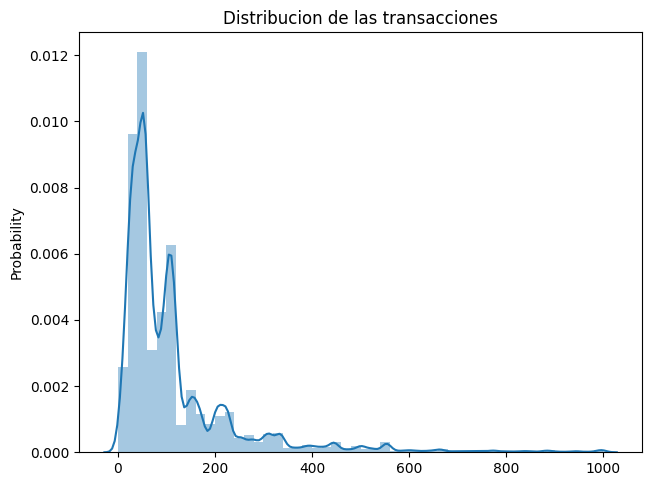

In [18]:
plt.figure(figsize=(16,12))
plt.subplot(221)
g = sns.distplot(fraudmer[fraudmer['TransactionAmt']<= 1000]['TransactionAmt'])
g.set_title("Distribucion de las transacciones")
g.set_xlabel("")
g.set_ylabel("Probability")

La variable TransactionAmt tiene una tendencia de distribución a la izquierda, donde la mayoría de compras se encuentran entre un rango de 0 a 200 dólares, se puede notar que a medida que aumenta el costo de la transacción el número de datos va disminuyendo, además que se puede ver un pequeño repunte en los datos alrededor de 1000.

## Analisis de isFraud

In [19]:
fraudmer.isFraud.value_counts()

isFraud
0    569877
1     20663
Name: count, dtype: int64

In [20]:
fraudmer.isFraud.describe().T

count    590540.000000
mean          0.034990
std           0.183755
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: isFraud, dtype: float64

in is fraud

In [21]:
plt.title('Fraud distribution')
sns.countplot(x=fraudmer.isFraud)
plt.xlabel('0=NO 1=YES')
plt.ylabel('Frequency')
plt.show()

se puede notar que existe un gran desbalance de datos, donde en menos del 10% de datos se detecto que se cometió fraude, siendo indicado por 1.

##Analisis de ProductCD

In [22]:
fraudmer.ProductCD.value_counts()

ProductCD
W    439670
C     68519
R     37699
H     33024
S     11628
Name: count, dtype: int64

In [23]:
fraudmer.ProductCD.describe()

count     590540
unique         5
top            W
freq      439670
Name: ProductCD, dtype: object

In [24]:
plt.title('Tipo de compra')
sns.countplot(x=fraudmer.ProductCD)
plt.xlabel('tipo')
plt.ylabel('Frequency')
plt.show()

En este caso, el tipo de compra más realizada fue el de tipo w, seguido en un desde un gran marguen el tipo de compra C el cual mantiene una frecuencia más cercana con el resto de los datos.

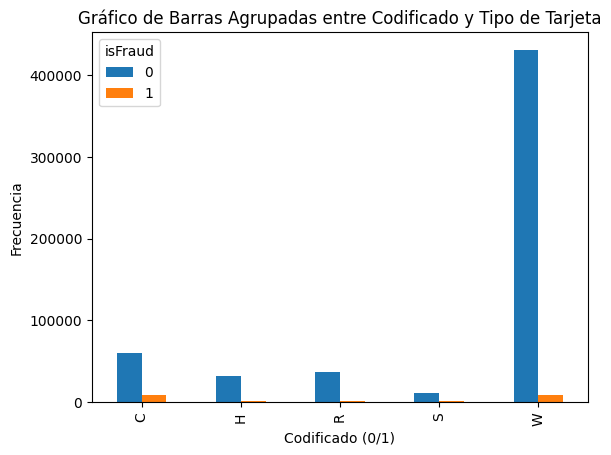

In [25]:
CD = pd.crosstab(fraudmer['ProductCD'], fraudmer['isFraud'])
CD.plot(kind='bar', stacked=False)
#etiquetas
plt.xlabel('Codificado (0/1)')
plt.ylabel('Frecuencia')
plt.title('Gráfico de Barras Agrupadas entre Codificado y Tipo de Tarjeta')

plt.show()

en este analisis cruzado es curioso notar que el producto de tipo "C" a pesar de ser mucho menos menos que el producto "w", tuvieron una cantidad de datos parecida en la posibilidad de que sea fraude.

## informacion de las variables CARD

Ahora entraremos en la informacion que se tiene en el dataset segun el tipo que contienen las variables de card, que van del 1 al 6

In [26]:
resumetable(fraudmer[['card1', 'card2', 'card3', 'card4','card5', 'card6']])

Dataset Shape: (590540, 6)


Name   dtypes  Missing  Uniques First Value Second Value Third Value  \
0  card1    int64        0    13553       13926         2755        4663   
1  card2  float64     8933      500         NaN        404.0       490.0   
2  card3  float64     1565      114       150.0        150.0       150.0   
3  card4   object     1577        4    discover   mastercard        visa   
4  card5  float64     4259      119       142.0        102.0       166.0   
5  card6   object     1571        4      credit       credit       debit   

   Entropy  
0     9.97  
1     6.32  
2     0.68  
3     1.09  
4     2.66  
5     0.82

En este caso, se nota la existencia de datos vacíos en la mayoría de estas variables y que al parecer todas mantienen ciertos datos de carácter único, siendo de especial interés aquellos que se encuentran en card 4 y 6 los cuales al parecer se refieren respectivamente al tipo de tarjeta y al método de pago de ellas.


CARD 1

In [27]:
fraudmer.card1.value_counts()

card1
7919     14932
9500     14162
15885    10361
17188    10344
15066     7945
         ...  
17084        1
14620        1
11440        1
13231        1
18038        1
Name: count, Length: 13553, dtype: int64

In [28]:
fraudmer.card1.describe()

count    590540.000000
mean       9898.734658
std        4901.170153
min        1000.000000
25%        6019.000000
50%        9678.000000
75%       14184.000000
max       18396.000000
Name: card1, dtype: float64

In [29]:
plt.figure(figsize=(14, 22))
plt.subplot(413)
g = sns.distplot(fraudmer[fraudmer['isFraud'] == 1]['card1'], color='purple', kde=False,label='Fraud')
g = sns.distplot(fraudmer[fraudmer['isFraud'] == 0]['card1'], kde=False,label='NoFraud')
g.legend()
g.set_title("Card 1 Values Distribution by Target", fontsize=20)
g.set_xlabel("Card 1 Values", fontsize=18)
g.set_ylabel("Probability", fontsize=18)
plt.show()

se puede observar que el mayor margen de fraude se encuentra alrededor de los valores cerca 10000 de la información que hace parte de card 1, aunque en cierta medida también se encuentran distribuidas en todos los datos de la variable

CARD2

In [30]:
fraudmer.card2.value_counts()

card2
321.0    48935
111.0    45191
555.0    41995
490.0    38145
583.0    21803
         ...  
388.0       39
153.0       38
557.0       37
473.0       18
582.0       14
Name: count, Length: 500, dtype: int64

In [31]:
fraudmer.card2.describe()

count    581607.000000
mean        362.555488
std         157.793246
min         100.000000
25%         214.000000
50%         361.000000
75%         512.000000
max         600.000000
Name: card2, dtype: float64

In [32]:
plt.figure(figsize=(14, 22))
plt.subplot(413)
g2 = sns.distplot(fraudmer[fraudmer['isFraud'] == 1]['card2'], color='purple', kde=False,label='Fraud')
g2 = sns.distplot(fraudmer[fraudmer['isFraud'] == 0]['card2'], kde=False,label='NoFraud')
g2.legend()
g2.set_title("Card 2 Values Distribution by Target", fontsize=20)
g2.set_xlabel("Card 2 Values", fontsize=18)
g2.set_ylabel("Probability", fontsize=18)
plt.show()

En CARD 2 al parecer los datos se encuentran enfocados en ciertos valores de la variable, así, además pareciera que aquellos que cometieron fraude se encuentran debajo de estos valores de datos que se encuentran enfocados.

CARD3

In [33]:
fraudmer.card3.value_counts()

card3
150.0    521287
185.0     56346
106.0      1571
144.0      1252
146.0      1252
          ...  
224.0         1
199.0         1
221.0         1
209.0         1
173.0         1
Name: count, Length: 114, dtype: int64

In [34]:
fraudmer.card3.describe()

count    588975.000000
mean        153.194925
std          11.336444
min         100.000000
25%         150.000000
50%         150.000000
75%         150.000000
max         231.000000
Name: card3, dtype: float64

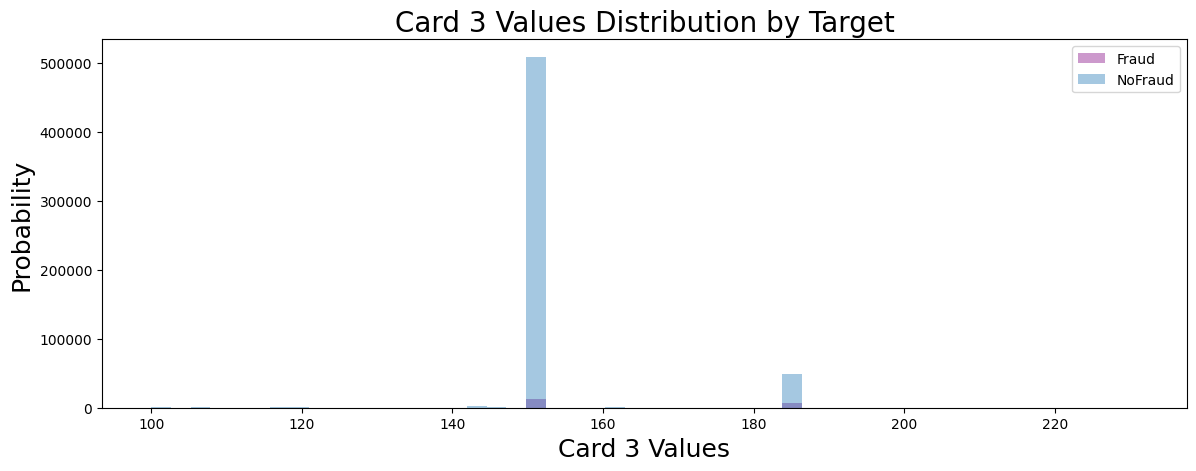

In [35]:
plt.figure(figsize=(14, 22))
plt.subplot(413)
g3 = sns.distplot(fraudmer[fraudmer['isFraud'] == 1]['card3'], color='purple', kde=False,label='Fraud')
g3 = sns.distplot(fraudmer[fraudmer['isFraud'] == 0]['card3'], kde=False,label='NoFraud')
g3.legend()
g3.set_title("Card 3 Values Distribution by Target", fontsize=20)
g3.set_xlabel("Card 3 Values", fontsize=18)
g3.set_ylabel("Probability", fontsize=18)
plt.show()

Aquí la información perteneciente a card3 es muy segada, en valuecounts.() y describe.() se puede notar que existen varios valores entre 100 y 231, pero según se muestra en la gráfica, la mayor cantidad de datos se encuentran solamente en dos valore en los cuales se encuentran también aquellos que cometieron fraude.

CARD4

In [36]:
fraudmer.card4.value_counts()

card4
visa                384767
mastercard          189217
american express      8328
discover              6651
Name: count, dtype: int64

In [37]:
fraudmer.card4.describe()

count     588963
unique         4
top         visa
freq      384767
Name: card4, dtype: object

In [38]:
plt.title('tipo de tarjeta utilizada')
sns.countplot(x=fraudmer.card4)
plt.xlabel('tipo de tarjeta')
plt.ylabel('Frequency')
plt.show()

en el caso de la tarjeta, la mas utilizada fue del tipo visa, seguido de la mastercard

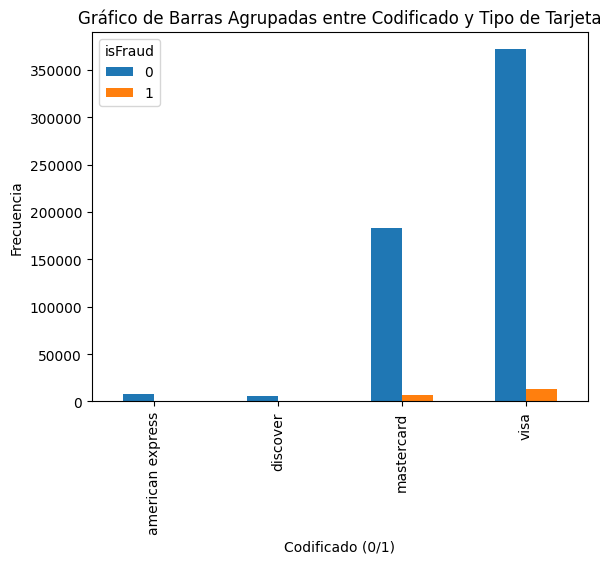

In [39]:
plot4 = pd.crosstab(fraudmer['card4'], fraudmer['isFraud'])

plot4.plot(kind='bar', stacked=False)

#etiquetas
plt.xlabel('Codificado (0/1)')
plt.ylabel('Frecuencia')
plt.title('Gráfico de Barras Agrupadas entre Codificado y Tipo de Tarjeta')

plt.show()

En este caso, el mayor tipo de fraude se encuentra en el tipo de tarjeta VISA, seguido del tipo MasterCard, siendo coherente con la distribución de los datos en esta variable.

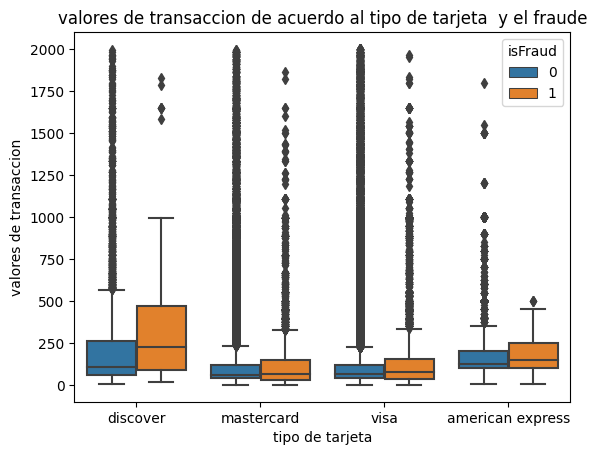

In [40]:
sns.boxplot(x="card4", y="TransactionAmt",hue='isFraud',data=fraudmer[fraudmer['TransactionAmt'] <= 2000] )

# Add labels and title
plt.xlabel("tipo de tarjeta")
plt.ylabel("valores de transaccion")
plt.title("valores de transaccion de acuerdo al tipo de tarjeta  y el fraude")

# Show the plot
plt.show()

CARD5

In [41]:
fraudmer.card5.value_counts()

card5
226.0    296546
224.0     81513
166.0     57140
102.0     29105
117.0     25941
          ...  
221.0         1
167.0         1
115.0         1
165.0         1
234.0         1
Name: count, Length: 119, dtype: int64

In [42]:
fraudmer.card5.describe()

count    586281.000000
mean        199.278897
std          41.244453
min         100.000000
25%         166.000000
50%         226.000000
75%         226.000000
max         237.000000
Name: card5, dtype: float64

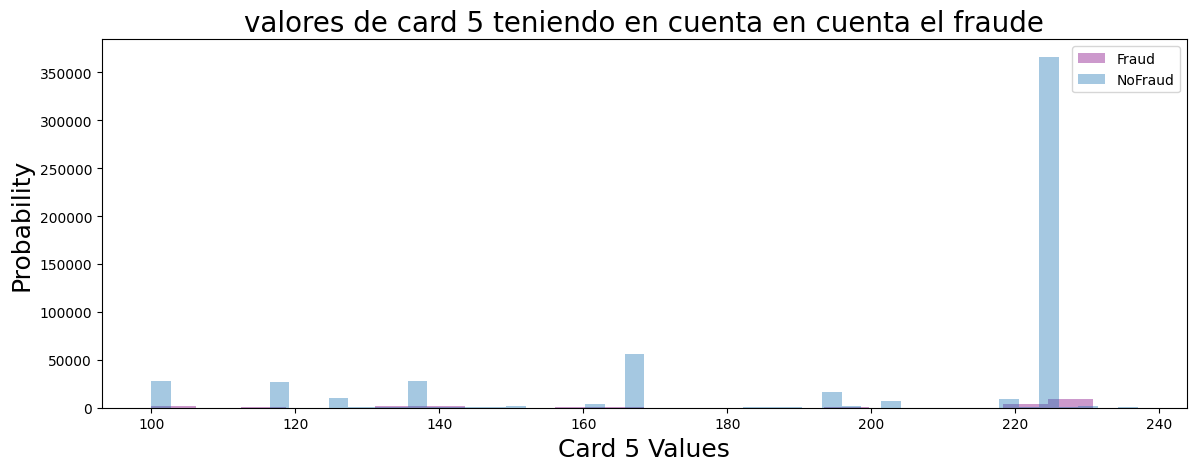

In [43]:
plt.figure(figsize=(14, 22))
plt.subplot(413)
g = sns.distplot(fraudmer[fraudmer['isFraud'] == 1]['card5'], color='purple', kde=False,label='Fraud')
g = sns.distplot(fraudmer[fraudmer['isFraud'] == 0]['card5'], kde=False,label='NoFraud')
g.legend()
g.set_title("valores de card 5 teniendo en cuenta en cuenta el fraude", fontsize=20)
g.set_xlabel("Card 5 Values", fontsize=18)
g.set_ylabel("Probability", fontsize=18)
plt.show()

Al igual que sucede con CARD2 Y 3, estos datos parecieran que se encuentran muy enfocados en ciertos valores de la variable, es curioso notar que aquellos que cometieron fraude no se encuentran estrictamente en el valor que contiene más datos, sino que se mantienen alrededor de estos.

Card6

In [44]:
plt.title('Forma de pago')
sns.countplot(x=fraudmer.card6)
plt.xlabel('tipo')
plt.ylabel('Frequency')
plt.show()

In [45]:
fraudmer.card6.value_counts()

card6
debit              439938
credit             148986
debit or credit        30
charge card            15
Name: count, dtype: int64

existen por mucho mas datos de forma de pago tipo debido

In [46]:
fraudmer.card6.describe()

count     588969
unique         4
top        debit
freq      439938
Name: card6, dtype: object

In [47]:
plot6 = pd.crosstab(fraudmer['card6'], fraudmer['isFraud'])

plot6.plot(kind='bar', stacked=False)

#etiquetas
plt.xlabel('Codificado (0/1)')
plt.ylabel('Frecuencia')
plt.title('Gráfico de Barras Agrupadas entre Codificado y Tipo de Tarjeta')

plt.show()

A pesar de la diferencia de cantidad entre los datos de card 6, ambos tipos de tarjeta pareciera que tuvieran la misma cantidad de deteccion de fraude, se podria decir que 'credit' tiene una tasa de aparicion de fraude mayor si se tiene en cuenta el total de datos

Informacion de Transaction DT

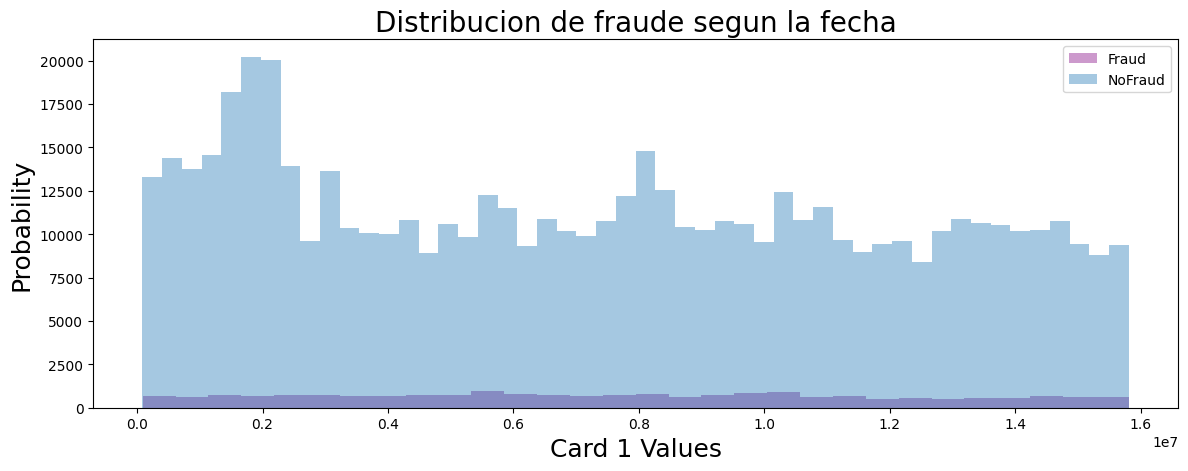

In [48]:
plt.figure(figsize=(14, 22))
plt.subplot(413)
g = sns.distplot(fraudmer[fraudmer['isFraud'] == 1]['TransactionDT'], color='purple', kde=False,label='Fraud')
g = sns.distplot(fraudmer[fraudmer['isFraud'] == 0]['TransactionDT'], kde=False,label='NoFraud')
g.legend()
g.set_title("Distribucion de fraude segun la fecha", fontsize=20)
g.set_xlabel("Card 1 Values", fontsize=18)
g.set_ylabel("Probability", fontsize=18)
plt.show()

aunque la informacion se encuentra codificada, se observa que no existe una cierta relacion de un dia especifico para cometer fraude, el acto de cometer fraude no esta relacionado con el dia pareciera que fuera constante, con pequeños valores mas altos entre 0.5-0.6,0.8 y 1.0.

Informacion P_emaildomain

In [49]:
fraudmer.P_emaildomain.value_counts()

P_emaildomain
gmail.com           228355
yahoo.com           100934
hotmail.com          45250
anonymous.com        36998
aol.com              28289
comcast.net           7888
icloud.com            6267
outlook.com           5096
msn.com               4092
att.net               4033
live.com              3041
sbcglobal.net         2970
verizon.net           2705
ymail.com             2396
bellsouth.net         1909
yahoo.com.mx          1543
me.com                1522
cox.net               1393
optonline.net         1011
charter.net            816
live.com.mx            749
rocketmail.com         664
mail.com               559
earthlink.net          514
gmail                  496
outlook.es             438
mac.com                436
juno.com               322
aim.com                315
hotmail.es             305
roadrunner.com         305
windstream.net         305
hotmail.fr             295
frontier.com           280
embarqmail.com         260
web.de                 240
netzero.com   

In [50]:
fraudmer.P_emaildomain.describe()

count        496084
unique           59
top       gmail.com
freq         228355
Name: P_emaildomain, dtype: object

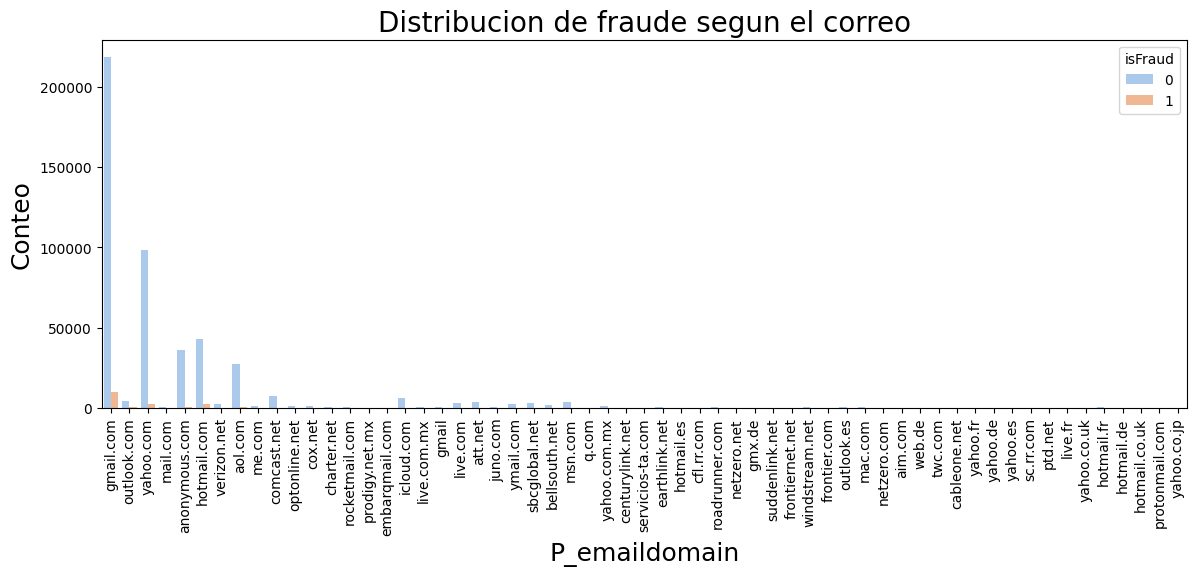

In [51]:
plt.figure(figsize=(14, 22))
plt.subplot(413)
g = sns.countplot(data=fraudmer, x='P_emaildomain', hue='isFraud', palette='pastel')
g.set_title("Distribucion de fraude segun el correo", fontsize=20)
g.set_xlabel("P_emaildomain", fontsize=18)
g.set_ylabel("Conteo", fontsize=18)
plt.xticks(rotation=90)
plt.show()


La mayoria de usuarios en ese caso usaron gmail, asi ademas, la mayoria de fraudes al parecer tambien se realizaron en este tipo de correos

Informacion R_emaildomain

In [52]:
fraudmer.R_emaildomain.value_counts()

R_emaildomain
gmail.com           57147
hotmail.com         27509
anonymous.com       20529
yahoo.com           11842
aol.com              3701
outlook.com          2507
comcast.net          1812
yahoo.com.mx         1508
icloud.com           1398
msn.com               852
live.com              762
live.com.mx           754
verizon.net           620
me.com                556
sbcglobal.net         552
cox.net               459
outlook.es            433
att.net               430
bellsouth.net         422
hotmail.fr            293
hotmail.es            292
web.de                237
mac.com               218
ymail.com             207
prodigy.net.mx        207
optonline.net         187
gmx.de                147
yahoo.fr              137
charter.net           127
mail.com              122
hotmail.co.uk         105
gmail                  95
earthlink.net          79
yahoo.de               75
rocketmail.com         69
embarqmail.com         68
scranton.edu           63
yahoo.es               5

In [53]:
fraudmer.R_emaildomain.describe()

count        137291
unique           60
top       gmail.com
freq          57147
Name: R_emaildomain, dtype: object

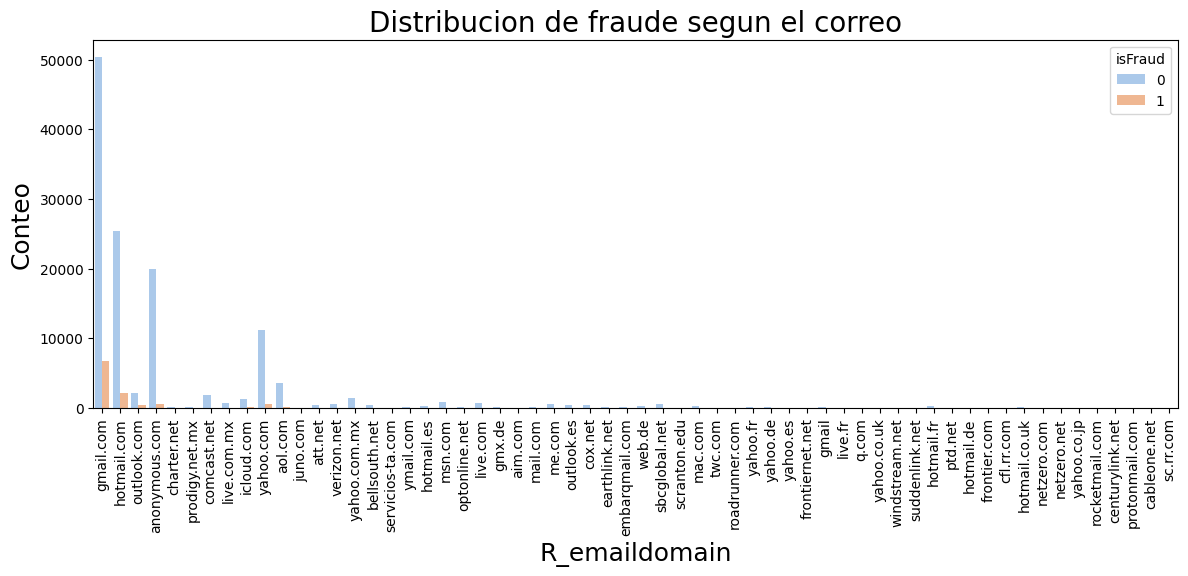

In [54]:
plt.figure(figsize=(14, 22))
plt.subplot(413)
g = sns.countplot(data=fraudmer, x='R_emaildomain', hue='isFraud', palette='pastel')
g.set_title("Distribucion de fraude segun el correo", fontsize=20)
g.set_xlabel("R_emaildomain", fontsize=18)
g.set_ylabel("Conteo", fontsize=18)
plt.xticks(rotation=90)
plt.show()

En R_emaildomain se repite tambien la tendencia de p_emaildomain, en gmail pareciera que se cometen los fraudes, seguido de hotmail y es interesante que existe un porcentaje de fraude de un dominio denomidano anonymous.com

A pesar de que la informacion entre p_emaildomain y R_emaildomain parecen relacionadas, pareciera que la mayoria de datos de esta segunda segunda se encuentran vacios

informacion DeviceType

In [55]:
fraudmer.DeviceType.describe()

count      140810
unique          2
top       desktop
freq        85165
Name: DeviceType, dtype: object

In [56]:
fraudmer.DeviceType.value_counts()

DeviceType
desktop    85165
mobile     55645
Name: count, dtype: int64

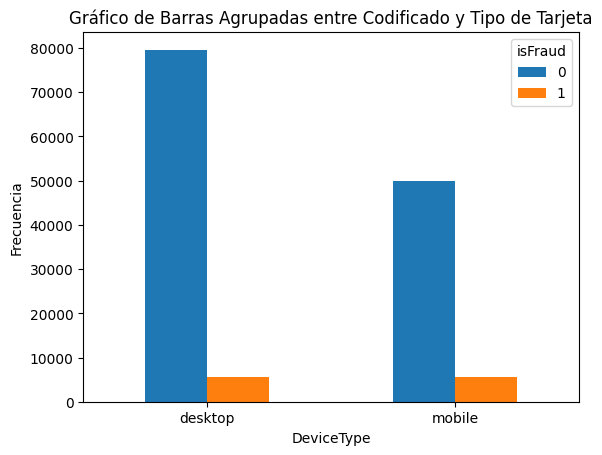

In [57]:
card4p = pd.crosstab(fraudmer['DeviceType'], fraudmer['isFraud'])
ax = card4p.plot(kind='bar', stacked=False)
ax.set_xticklabels(card4p.index, rotation=0)
#etiquetas
plt.ylabel('Frecuencia')
plt.title('Gráfico de Barras Agrupadas entre Codificado y Tipo de Tarjeta')

plt.show()

lo mismo se repite con devicetype, pareciera que la mayoria de datos se encuentran vacios


En este caso también se puede encontrar un caso parecido a CARD6, a pesar de que en desktop existe un mayor número de transacciones realizadas, pareciera que los dispositivos móviles tienen una tasa de aparición de fraude mayor si se tiene en cuenta el total de datos.


Informacion Device Info

In [58]:
fraudmer.DeviceInfo.describe()

count      118666
unique       1786
top       Windows
freq        47722
Name: DeviceInfo, dtype: object

In [59]:
fraudmer.DeviceInfo.value_counts()

DeviceInfo
Windows        47722
iOS Device     19782
MacOS          12573
Trident/7.0     7440
rv:11.0         1901
               ...  
LGMS345            1
verykool           1
XT1072             1
LG-H931            1
0PJA2              1
Name: count, Length: 1786, dtype: int64

## Analizis de datos extensos

Como se menciono mas arriba, datos como C, V, D Y tienen una gran extension de variables, en este caso seria analizar una cierta cantidad de estas variables, coger algunas del del inicio, otras de la mitad y otras cerca de la final con el fin de conocer si el datos comienzan a estar vacios entre mas alto sea el numero de la variable o si estas variables manejan datos parecidos

VARIABLES DE TIPO C

In [60]:
resumetable(fraudmer[['C1', 'C2', 'C3', 'C4','C5', 'C6','C7','C8','C9','C12', 'C14']])

Dataset Shape: (590540, 11)


Name   dtypes  Missing  Uniques  First Value  Second Value  Third Value  \
0    C1  float64        0     1657          1.0           1.0          1.0   
1    C2  float64        0     1216          1.0           1.0          1.0   
2    C3  float64        0       27          0.0           0.0          0.0   
3    C4  float64        0     1260          0.0           0.0          0.0   
4    C5  float64        0      319          0.0           0.0          0.0   
5    C6  float64        0     1328          1.0           1.0          1.0   
6    C7  float64        0     1103          0.0           0.0          0.0   
7    C8  float64        0     1253          0.0           0.0          0.0   
8    C9  float64        0      205          1.0           0.0          1.0   
9   C12  float64        0     1199          0.0           0.0          0.0   
10  C14  float64        0     1108          1.0           1.0          1.0   

    Entropy  
0      2.72  
1      2.75  
2      0.04  
3      1.12  
4      2.06  
5      2.52  
6      0.71  
7      1.25  
8      2.62  
9      0.95  
10     2.67

In [61]:
fraudmer.C1.value_counts()

C1
1.0       316791
2.0       105071
3.0        51315
4.0        28845
5.0        17922
           ...  
3433.0         1
3434.0         1
3435.0         1
3436.0         1
1500.0         1
Name: count, Length: 1657, dtype: int64

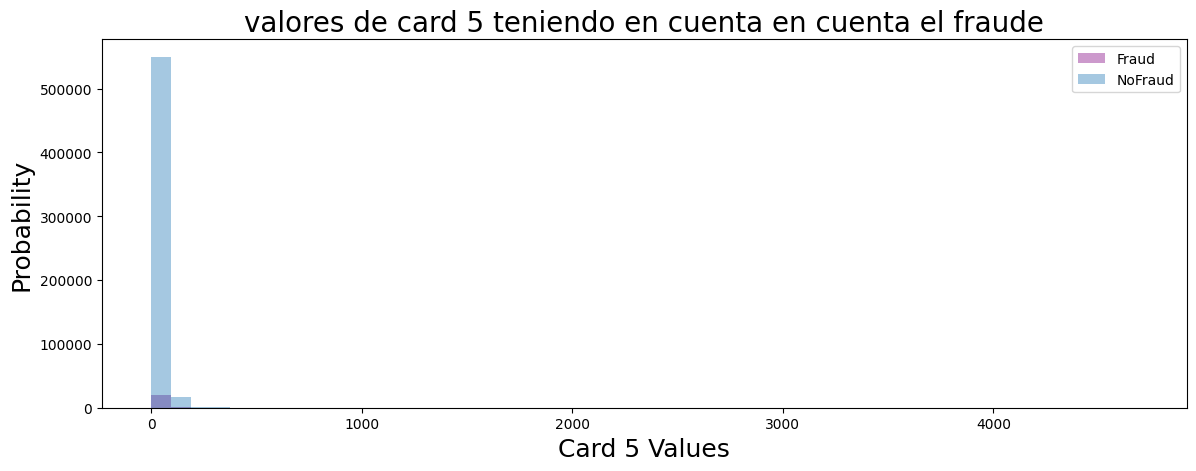

In [62]:
plt.figure(figsize=(14, 22))
plt.subplot(413)
g = sns.distplot(fraudmer[fraudmer['isFraud'] == 1]['C1'], color='purple', kde=False,label='Fraud')
g = sns.distplot(fraudmer[fraudmer['isFraud'] == 0]['C1'], kde=False,label='NoFraud')
g.legend()
g.set_title("valores de card 5 teniendo en cuenta en cuenta el fraude", fontsize=20)
g.set_xlabel("Card 5 Values", fontsize=18)
g.set_ylabel("Probability", fontsize=18)
plt.show()

In [165]:
resumetable(fraudmer[['D1', 'D2', 'D3', 'D6','D8', 'D9','D10','D12','D13','D14', 'D15']])

Dataset Shape: (590540, 11)


Name   dtypes  Missing  Uniques  First Value  Second Value  Third Value  \
0    D1  float64     1269      641         14.0           0.0          0.0   
1    D2  float64   280797      641          NaN           NaN          NaN   
2    D3  float64   262878      649         13.0           NaN          NaN   
3    D6  float64   517353      829          NaN           NaN          NaN   
4    D8  float64   515614    12353          NaN           NaN          NaN   
5    D9  float64   515614       24          NaN           NaN          NaN   
6   D10  float64    76022      818         13.0           0.0          0.0   
7   D12  float64   525823      635          NaN           NaN          NaN   
8   D13  float64   528588      577          NaN           NaN          NaN   
9   D14  float64   528353      802          NaN           NaN          NaN   
10  D15  float64    89113      859          0.0           0.0        315.0   

    Entropy  
0      5.57  
1      8.57  
2      5.60  
3      4.09  
4     11.32  
5      4.29  
6      6.09  
7      3.70  
8      2.26  
9      3.14  
10     6.88

In [166]:
plt.figure(figsize=(14, 22))
plt.subplot(413)
g = sns.distplot(fraudmer[fraudmer['isFraud'] == 1]['D1'], color='purple', kde=False,label='Fraud')
g = sns.distplot(fraudmer[fraudmer['isFraud'] == 0]['D1'], kde=False,label='NoFraud')
g.legend()
g.set_title("valores de D1 teniendo en cuenta en cuenta el fraude", fontsize=20)
g.set_xlabel("D1 Values", fontsize=18)
g.set_ylabel("Probability", fontsize=18)
plt.show()

In [168]:
plt.figure(figsize=(14, 22))
plt.subplot(413)
g = sns.distplot(fraudmer[fraudmer['isFraud'] == 1]['D12'], color='purple', kde=False,label='Fraud')
g = sns.distplot(fraudmer[fraudmer['isFraud'] == 0]['D12'], kde=False,label='NoFraud')
g.legend()
g.set_title("valores de D12 teniendo en cuenta en cuenta el fraude", fontsize=20)
g.set_xlabel("D6 Values", fontsize=18)
g.set_ylabel("Probability", fontsize=18)
plt.show()

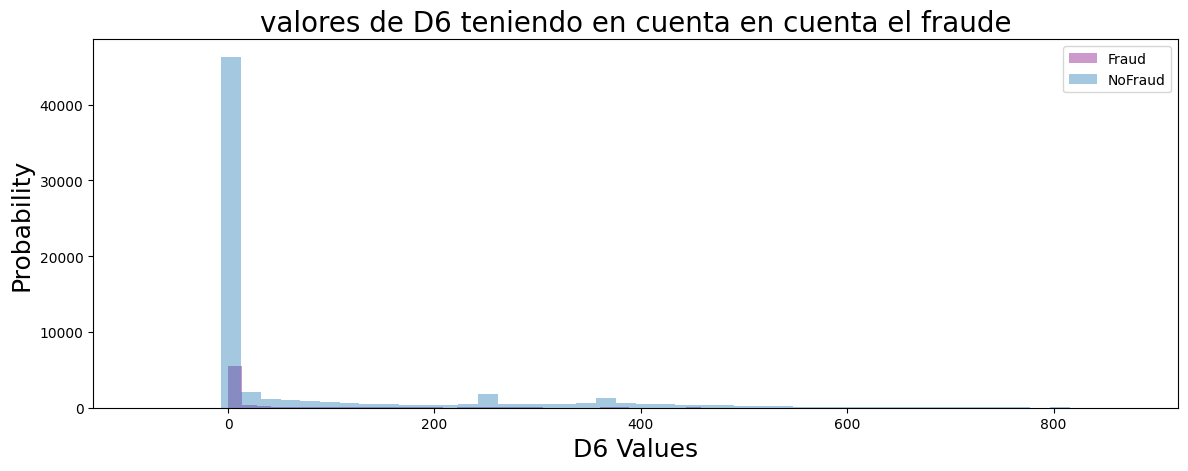

In [169]:
plt.figure(figsize=(14, 22))
plt.subplot(413)
g = sns.distplot(fraudmer[fraudmer['isFraud'] == 1]['D6'], color='purple', kde=False,label='Fraud')
g = sns.distplot(fraudmer[fraudmer['isFraud'] == 0]['D6'], kde=False,label='NoFraud')
g.legend()
g.set_title("valores de D6 teniendo en cuenta en cuenta el fraude", fontsize=20)
g.set_xlabel("D6 Values", fontsize=18)
g.set_ylabel("Probability", fontsize=18)
plt.show()

segun las imagenes, la variable isfraud sigue latendencia de todos los datos, el mayor porcentaje de valores de fraude se encuentra en aquellos valores donde se acumula un mayor porcentaje de datos

In [64]:
resumetable(fraudmer[['M1', 'M2', 'M3', 'M4','M5', 'M6','M7','M8','M9']])

Dataset Shape: (590540, 9)


Name  dtypes  Missing  Uniques First Value Second Value Third Value  Entropy
0   M1  object   271100        2           T          NaN           T     0.00
1   M2  object   271100        2           T          NaN           T     0.49
2   M3  object   271100        2           T          NaN           T     0.75
3   M4  object   281444        3          M2           M0          M0     1.31
4   M5  object   350482        2           F            T           F     0.99
5   M6  object   169360        2           T            T           F     1.00
6   M7  object   346265        2         NaN          NaN           F     0.57
7   M8  object   346252        2         NaN          NaN           F     0.95
8   M9  object   346252        2         NaN          NaN           F     0.63

In [161]:
plt.title('Forma de pago')
sns.countplot(x=fraudmer.M3)
plt.xlabel('tipo')
plt.ylabel('Frequency')
plt.show()

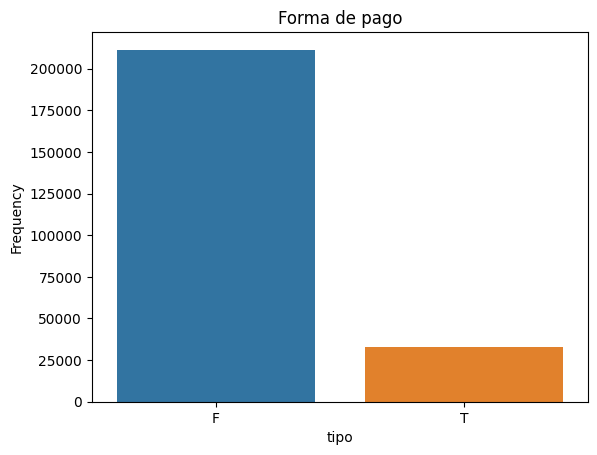

In [162]:
plt.title('Forma de pago')
sns.countplot(x=fraudmer.M7)
plt.xlabel('tipo')
plt.ylabel('Frequency')
plt.show()

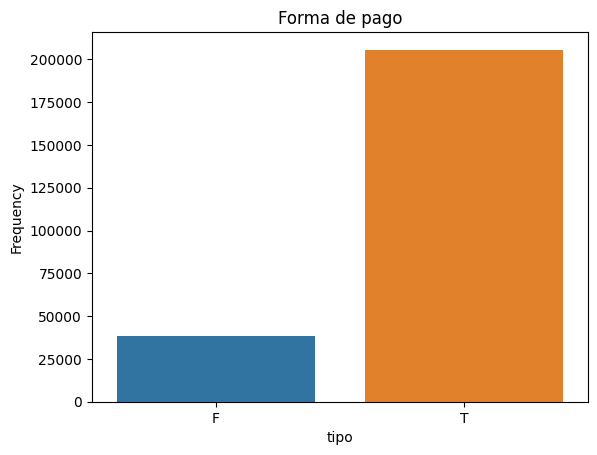

In [164]:
plt.title('Forma de pago')
sns.countplot(x=fraudmer.M9)
plt.xlabel('tipo')
plt.ylabel('Frequency')
plt.show()

al parecer en este tipo de variable M existen 2 tipo de datos, T, F y NAn, es importante notar que alparecer existen datos vacios de alredor del 50% o mas de los datos

In [65]:
resumetable(fraudmer[['V1', 'V2', 'V100', 'V101','V102', 'V168','V169','V200','V210','V250', 'V339']])

Dataset Shape: (590540, 11)


Name   dtypes  Missing  Uniques  First Value  Second Value  Third Value  \
0     V1  float64   279287        2          1.0           NaN          1.0   
1     V2  float64   279287        9          1.0           NaN          1.0   
2   V100  float64      314       29          0.0           0.0          0.0   
3   V101  float64      314      870          0.0           0.0          0.0   
4   V102  float64      314     1285          1.0           0.0          0.0   
5   V168  float64   450909      965          NaN           NaN          NaN   
6   V169  float64   450721       20          NaN           NaN          NaN   
7   V200  float64   450721       46          NaN           NaN          NaN   
8   V210  float64   450721     2836          NaN           NaN          NaN   
9   V250  float64   449124       19          NaN           NaN          NaN   
10  V339  float64   508189      334          NaN           NaN          NaN   

    Entropy  
0      0.00  
1      0.27  
2      0.88  
3      0.45  
4      0.73  
5      1.72  
6      0.50  
7      0.94  
8      1.62  
9      0.88  
10     1.13

In [170]:
plt.figure(figsize=(14, 22))
plt.subplot(413)
g = sns.distplot(fraudmer[fraudmer['isFraud'] == 1]['V1'], color='purple', kde=False,label='Fraud')
g = sns.distplot(fraudmer[fraudmer['isFraud'] == 0]['D1'], kde=False,label='NoFraud')
g.legend()
g.set_title("valores de V1 teniendo en cuenta en cuenta el fraude", fontsize=20)
g.set_xlabel("V1 Values", fontsize=18)
g.set_ylabel("Probability", fontsize=18)
plt.show()

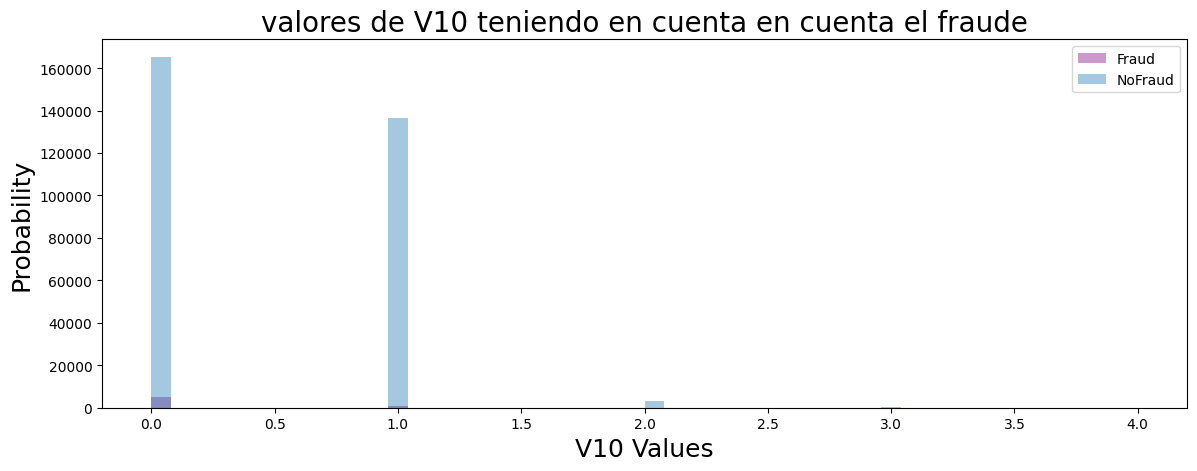

In [171]:
plt.figure(figsize=(14, 22))
plt.subplot(413)
g = sns.distplot(fraudmer[fraudmer['isFraud'] == 1]['V10'], color='purple', kde=False,label='Fraud')
g = sns.distplot(fraudmer[fraudmer['isFraud'] == 0]['V10'], kde=False,label='NoFraud')
g.legend()
g.set_title("valores de V10 teniendo en cuenta en cuenta el fraude", fontsize=20)
g.set_xlabel("V10 Values", fontsize=18)
g.set_ylabel("Probability", fontsize=18)
plt.show()

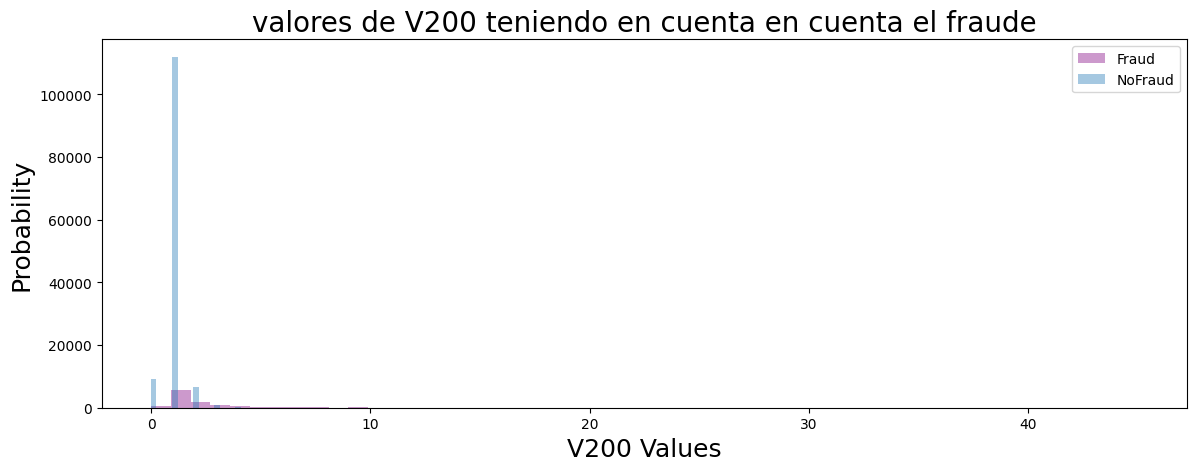

In [174]:
plt.figure(figsize=(14, 22))
plt.subplot(413)
g = sns.distplot(fraudmer[fraudmer['isFraud'] == 1]['V200'], color='purple', kde=False,label='Fraud')
g = sns.distplot(fraudmer[fraudmer['isFraud'] == 0]['V200'], kde=False,label='NoFraud')
g.legend()
g.set_title("valores de V200 teniendo en cuenta en cuenta el fraude", fontsize=20)
g.set_xlabel("V200 Values", fontsize=18)
g.set_ylabel("Probability", fontsize=18)
plt.show()

En este tipo de variables V al parecer al igual que aquellas que pertenecen al conjunto de variables D6, aquellos que cometieron fraude siguen la tendencia de estar donde se encuentran la mayoria de datos

## preparacion de datos

ahora, arriba se menciono que hay datos que le faltan la mayoria de datos, por lo cual seria importante darle un manejo mas adelante

In [66]:
missing_percentage = (faltante / len(fraudmer)) * 100
missing_data_info = pd.DataFrame({
    'Columna': faltante.index,
    'Valores Faltantes': faltante.values,
    'Porcentaje Faltante': missing_percentage.values
})

In [67]:
missing_data_info.value_counts()

Columna  Valores Faltantes  Porcentaje Faltante
C1       0                  0.000000               1
V314     1269               0.214888               1
V324     508189             86.054967              1
V323     508189             86.054967              1
V322     508189             86.054967              1
                                                  ..
V185     450721             76.323534              1
V184     450721             76.323534              1
V183     450909             76.355370              1
V182     450909             76.355370              1
isFraud  0                  0.000000               1
Name: count, Length: 434, dtype: int64

con missing_data se hace un registro de las columnas que le faltan datos

In [68]:
corte = 0.7
missing_percentage = (fraudmer.isnull().sum() / len(fraudmer)).sort_values(ascending=False)

In [69]:
columns_to_drop = missing_percentage[missing_percentage > corte].index

In [70]:
fraudmer2 = fraudmer.drop(columns=columns_to_drop)

eliminamos las columnas cuyos datos faltantes equivalen al 70% o mas de sus datos.

In [71]:
fraudmer2

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
0             2987000        0          86400           68.50         W   
1             2987001        0          86401           29.00         W   
2             2987002        0          86469           59.00         W   
3             2987003        0          86499           50.00         W   
4             2987004        0          86506           50.00         H   
...               ...      ...            ...             ...       ...   
590535        3577535        0       15811047           49.00         W   
590536        3577536        0       15811049           39.50         W   
590537        3577537        0       15811079           30.95         W   
590538        3577538        0       15811088          117.00         W   
590539        3577539        0       15811131          279.95         W   

        card1  card2  card3       card4  card5  ...   V312        V313  \
0       13926    NaN  150.0    discover  142.0  ...    0.0    0.000000   
1        2755  404.0  150.0  mastercard  102.0  ...    0.0    0.000000   
2        4663  490.0  150.0        visa  166.0  ...    0.0    0.000000   
3       18132  567.0  150.0  mastercard  117.0  ...  135.0    0.000000   
4        4497  514.0  150.0  mastercard  102.0  ...    0.0    0.000000   
...       ...    ...    ...         ...    ...  ...    ...         ...   
590535   6550    NaN  150.0        visa  226.0  ...    0.0   47.950001   
590536  10444  225.0  150.0  mastercard  224.0  ...    0.0    0.000000   
590537  12037  595.0  150.0  mastercard  224.0  ...    0.0    0.000000   
590538   7826  481.0  150.0  mastercard  224.0  ...  117.0  317.500000   
590539  15066  170.0  150.0  mastercard  102.0  ...    0.0    0.000000   

              V314        V315  V316    V317   V318        V319        V320  \
0         0.000000    0.000000   0.0   117.0    0.0    0.000000    0.000000   
1         0.000000    0.000000   0.0     0.0    0.0    0.000000    0.000000   
2         0.000000    0.000000   0.0     0.0    0.0    0.000000    0.000000   
3         0.000000    0.000000  50.0  1404.0  790.0    0.000000    0.000000   
4         0.000000    0.000000   0.0     0.0    0.0    0.000000    0.000000   
...            ...         ...   ...     ...    ...         ...         ...   
590535   47.950001   47.950001   0.0     0.0    0.0    0.000000    0.000000   
590536    0.000000    0.000000   0.0     0.0    0.0    0.000000    0.000000   
590537    0.000000    0.000000   0.0     0.0    0.0    0.000000    0.000000   
590538  669.500000  317.500000   0.0  2234.0    0.0    0.000000    0.000000   
590539    0.000000    0.000000   0.0     0.0    0.0  279.950012  279.950012   

              V321  
0         0.000000  
1         0.000000  
2         0.000000  
3         0.000000  
4         0.000000  
...            ...  
590535    0.000000  
590536    0.000000  
590537    0.000000  
590538    0.000000  
590539  279.950012  

[590540 rows x 226 columns]

pasamos de tener 403 columnas a 226 columnas cuando eliminamos aquellas columnas que le faltan el 70% de datos

In [72]:
fraudmer2.columns.values

array(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'P_emaildomain', 'C1', 'C2', 'C3', 'C4',
       'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
       'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15', 'M1', 'M2',
       'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4',
       'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14',
       'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23',
       'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32',
       'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41',
       'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50',
       'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59',
       'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68',
       'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77',
    

Creamos un .values del nuevo dataset para poder saber cuales columnas quedaron despues de eliminar el 70% de columnas con datos faltantes

igualmente sigue siendo un numero considerable de columnas, por lo cual seria importante reazlizar una limpieza mas grade de columnas

In [73]:
fraudmer2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 226 entries, TransactionID to V321
dtypes: float64(209), int64(4), object(13)
memory usage: 1018.2+ MB


In [74]:
for f in fraudmer2.drop('isFraud', axis=1).columns:
    if fraudmer2[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(fraudmer2[f].values))
        fraudmer2[f] = lbl.transform(list(fraudmer2[f].values))

con este 'for' convertimos todas las columnas que contienen objects en float, realizamos lo mismo con el data 'fraudmer' que contiene columnas eliminadas del 70% para comparar scores

In [75]:
fraudmer2

TransactionID  isFraud  TransactionDT  TransactionAmt  ProductCD  \
0             2987000        0          86400           68.50          4   
1             2987001        0          86401           29.00          4   
2             2987002        0          86469           59.00          4   
3             2987003        0          86499           50.00          4   
4             2987004        0          86506           50.00          1   
...               ...      ...            ...             ...        ...   
590535        3577535        0       15811047           49.00          4   
590536        3577536        0       15811049           39.50          4   
590537        3577537        0       15811079           30.95          4   
590538        3577538        0       15811088          117.00          4   
590539        3577539        0       15811131          279.95          4   

        card1  card2  card3  card4  card5  ...   V312        V313        V314  \
0       13926    NaN  150.0      1  142.0  ...    0.0    0.000000    0.000000   
1        2755  404.0  150.0      2  102.0  ...    0.0    0.000000    0.000000   
2        4663  490.0  150.0      4  166.0  ...    0.0    0.000000    0.000000   
3       18132  567.0  150.0      2  117.0  ...  135.0    0.000000    0.000000   
4        4497  514.0  150.0      2  102.0  ...    0.0    0.000000    0.000000   
...       ...    ...    ...    ...    ...  ...    ...         ...         ...   
590535   6550    NaN  150.0      4  226.0  ...    0.0   47.950001   47.950001   
590536  10444  225.0  150.0      2  224.0  ...    0.0    0.000000    0.000000   
590537  12037  595.0  150.0      2  224.0  ...    0.0    0.000000    0.000000   
590538   7826  481.0  150.0      2  224.0  ...  117.0  317.500000  669.500000   
590539  15066  170.0  150.0      2  102.0  ...    0.0    0.000000    0.000000   

              V315  V316    V317   V318        V319        V320        V321  
0         0.000000   0.0   117.0    0.0    0.000000    0.000000    0.000000  
1         0.000000   0.0     0.0    0.0    0.000000    0.000000    0.000000  
2         0.000000   0.0     0.0    0.0    0.000000    0.000000    0.000000  
3         0.000000  50.0  1404.0  790.0    0.000000    0.000000    0.000000  
4         0.000000   0.0     0.0    0.0    0.000000    0.000000    0.000000  
...            ...   ...     ...    ...         ...         ...         ...  
590535   47.950001   0.0     0.0    0.0    0.000000    0.000000    0.000000  
590536    0.000000   0.0     0.0    0.0    0.000000    0.000000    0.000000  
590537    0.000000   0.0     0.0    0.0    0.000000    0.000000    0.000000  
590538  317.500000   0.0  2234.0    0.0    0.000000    0.000000    0.000000  
590539    0.000000   0.0     0.0    0.0  279.950012  279.950012  279.950012  

[590540 rows x 226 columns]

In [76]:
fraudmer2
corr_matrix = fraudmer2.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]
fraudmer2.drop(fraudmer2[to_drop], axis=1)

TransactionID  isFraud  TransactionAmt  ProductCD  card1  card2  \
0             2987000        0           68.50          4  13926    NaN   
1             2987001        0           29.00          4   2755  404.0   
2             2987002        0           59.00          4   4663  490.0   
3             2987003        0           50.00          4  18132  567.0   
4             2987004        0           50.00          1   4497  514.0   
...               ...      ...             ...        ...    ...    ...   
590535        3577535        0           49.00          4   6550    NaN   
590536        3577536        0           39.50          4  10444  225.0   
590537        3577537        0           30.95          4  12037  595.0   
590538        3577538        0          117.00          4   7826  481.0   
590539        3577539        0          279.95          4  15066  170.0   

        card3  card4  card5  card6  ...  V284  V286  V288  V290  V291  V300  \
0       150.0      1  142.0      1  ...   0.0   0.0   0.0   1.0   1.0   0.0   
1       150.0      2  102.0      1  ...   0.0   0.0   0.0   1.0   1.0   0.0   
2       150.0      4  166.0      2  ...   0.0   0.0   0.0   1.0   1.0   0.0   
3       150.0      2  117.0      2  ...   0.0   0.0   0.0   1.0   1.0   0.0   
4       150.0      2  102.0      1  ...   0.0   0.0   0.0   1.0   1.0   0.0   
...       ...    ...    ...    ...  ...   ...   ...   ...   ...   ...   ...   
590535  150.0      4  226.0      2  ...   0.0   0.0   1.0   1.0   1.0   0.0   
590536  150.0      2  224.0      2  ...   0.0   0.0   0.0   1.0   1.0   0.0   
590537  150.0      2  224.0      2  ...   0.0   0.0   0.0   1.0   1.0   0.0   
590538  150.0      2  224.0      2  ...   1.0   0.0   1.0   1.0   2.0   0.0   
590539  150.0      2  102.0      1  ...   0.0   0.0   0.0   1.0   1.0   1.0   

        V305        V313        V314        V319  
0        1.0    0.000000    0.000000    0.000000  
1        1.0    0.000000    0.000000    0.000000  
2        1.0    0.000000    0.000000    0.000000  
3        1.0    0.000000    0.000000    0.000000  
4        1.0    0.000000    0.000000    0.000000  
...      ...         ...         ...         ...  
590535   1.0   47.950001   47.950001    0.000000  
590536   1.0    0.000000    0.000000    0.000000  
590537   1.0    0.000000    0.000000    0.000000  
590538   1.0  317.500000  669.500000    0.000000  
590539   1.0    0.000000    0.000000  279.950012  

[590540 rows x 92 columns]

In [77]:
fraudmer2=fraudmer2.drop(fraudmer2[to_drop], axis=1)
fraudmer2

TransactionID  isFraud  TransactionAmt  ProductCD  card1  card2  \
0             2987000        0           68.50          4  13926    NaN   
1             2987001        0           29.00          4   2755  404.0   
2             2987002        0           59.00          4   4663  490.0   
3             2987003        0           50.00          4  18132  567.0   
4             2987004        0           50.00          1   4497  514.0   
...               ...      ...             ...        ...    ...    ...   
590535        3577535        0           49.00          4   6550    NaN   
590536        3577536        0           39.50          4  10444  225.0   
590537        3577537        0           30.95          4  12037  595.0   
590538        3577538        0          117.00          4   7826  481.0   
590539        3577539        0          279.95          4  15066  170.0   

        card3  card4  card5  card6  ...  V284  V286  V288  V290  V291  V300  \
0       150.0      1  142.0      1  ...   0.0   0.0   0.0   1.0   1.0   0.0   
1       150.0      2  102.0      1  ...   0.0   0.0   0.0   1.0   1.0   0.0   
2       150.0      4  166.0      2  ...   0.0   0.0   0.0   1.0   1.0   0.0   
3       150.0      2  117.0      2  ...   0.0   0.0   0.0   1.0   1.0   0.0   
4       150.0      2  102.0      1  ...   0.0   0.0   0.0   1.0   1.0   0.0   
...       ...    ...    ...    ...  ...   ...   ...   ...   ...   ...   ...   
590535  150.0      4  226.0      2  ...   0.0   0.0   1.0   1.0   1.0   0.0   
590536  150.0      2  224.0      2  ...   0.0   0.0   0.0   1.0   1.0   0.0   
590537  150.0      2  224.0      2  ...   0.0   0.0   0.0   1.0   1.0   0.0   
590538  150.0      2  224.0      2  ...   1.0   0.0   1.0   1.0   2.0   0.0   
590539  150.0      2  102.0      1  ...   0.0   0.0   0.0   1.0   1.0   1.0   

        V305        V313        V314        V319  
0        1.0    0.000000    0.000000    0.000000  
1        1.0    0.000000    0.000000    0.000000  
2        1.0    0.000000    0.000000    0.000000  
3        1.0    0.000000    0.000000    0.000000  
4        1.0    0.000000    0.000000    0.000000  
...      ...         ...         ...         ...  
590535   1.0   47.950001   47.950001    0.000000  
590536   1.0    0.000000    0.000000    0.000000  
590537   1.0    0.000000    0.000000    0.000000  
590538   1.0  317.500000  669.500000    0.000000  
590539   1.0    0.000000    0.000000  279.950012  

[590540 rows x 92 columns]

In [78]:
fraudmer2

TransactionID  isFraud  TransactionAmt  ProductCD  card1  card2  \
0             2987000        0           68.50          4  13926    NaN   
1             2987001        0           29.00          4   2755  404.0   
2             2987002        0           59.00          4   4663  490.0   
3             2987003        0           50.00          4  18132  567.0   
4             2987004        0           50.00          1   4497  514.0   
...               ...      ...             ...        ...    ...    ...   
590535        3577535        0           49.00          4   6550    NaN   
590536        3577536        0           39.50          4  10444  225.0   
590537        3577537        0           30.95          4  12037  595.0   
590538        3577538        0          117.00          4   7826  481.0   
590539        3577539        0          279.95          4  15066  170.0   

        card3  card4  card5  card6  ...  V284  V286  V288  V290  V291  V300  \
0       150.0      1  142.0      1  ...   0.0   0.0   0.0   1.0   1.0   0.0   
1       150.0      2  102.0      1  ...   0.0   0.0   0.0   1.0   1.0   0.0   
2       150.0      4  166.0      2  ...   0.0   0.0   0.0   1.0   1.0   0.0   
3       150.0      2  117.0      2  ...   0.0   0.0   0.0   1.0   1.0   0.0   
4       150.0      2  102.0      1  ...   0.0   0.0   0.0   1.0   1.0   0.0   
...       ...    ...    ...    ...  ...   ...   ...   ...   ...   ...   ...   
590535  150.0      4  226.0      2  ...   0.0   0.0   1.0   1.0   1.0   0.0   
590536  150.0      2  224.0      2  ...   0.0   0.0   0.0   1.0   1.0   0.0   
590537  150.0      2  224.0      2  ...   0.0   0.0   0.0   1.0   1.0   0.0   
590538  150.0      2  224.0      2  ...   1.0   0.0   1.0   1.0   2.0   0.0   
590539  150.0      2  102.0      1  ...   0.0   0.0   0.0   1.0   1.0   1.0   

        V305        V313        V314        V319  
0        1.0    0.000000    0.000000    0.000000  
1        1.0    0.000000    0.000000    0.000000  
2        1.0    0.000000    0.000000    0.000000  
3        1.0    0.000000    0.000000    0.000000  
4        1.0    0.000000    0.000000    0.000000  
...      ...         ...         ...         ...  
590535   1.0   47.950001   47.950001    0.000000  
590536   1.0    0.000000    0.000000    0.000000  
590537   1.0    0.000000    0.000000    0.000000  
590538   1.0  317.500000  669.500000    0.000000  
590539   1.0    0.000000    0.000000  279.950012  

[590540 rows x 92 columns]

ahora pasamos de tener 226 columnas a 92 columnas, un numero considerablemente menor

In [80]:
fraudmer2

TransactionID  isFraud  TransactionAmt  ProductCD  card1  card2  \
0             2987000        0           68.50          4  13926    NaN   
1             2987001        0           29.00          4   2755  404.0   
2             2987002        0           59.00          4   4663  490.0   
3             2987003        0           50.00          4  18132  567.0   
4             2987004        0           50.00          1   4497  514.0   
...               ...      ...             ...        ...    ...    ...   
590535        3577535        0           49.00          4   6550    NaN   
590536        3577536        0           39.50          4  10444  225.0   
590537        3577537        0           30.95          4  12037  595.0   
590538        3577538        0          117.00          4   7826  481.0   
590539        3577539        0          279.95          4  15066  170.0   

        card3  card4  card5  card6  ...  V284  V286  V288  V290  V291  V300  \
0       150.0      1  142.0      1  ...   0.0   0.0   0.0   1.0   1.0   0.0   
1       150.0      2  102.0      1  ...   0.0   0.0   0.0   1.0   1.0   0.0   
2       150.0      4  166.0      2  ...   0.0   0.0   0.0   1.0   1.0   0.0   
3       150.0      2  117.0      2  ...   0.0   0.0   0.0   1.0   1.0   0.0   
4       150.0      2  102.0      1  ...   0.0   0.0   0.0   1.0   1.0   0.0   
...       ...    ...    ...    ...  ...   ...   ...   ...   ...   ...   ...   
590535  150.0      4  226.0      2  ...   0.0   0.0   1.0   1.0   1.0   0.0   
590536  150.0      2  224.0      2  ...   0.0   0.0   0.0   1.0   1.0   0.0   
590537  150.0      2  224.0      2  ...   0.0   0.0   0.0   1.0   1.0   0.0   
590538  150.0      2  224.0      2  ...   1.0   0.0   1.0   1.0   2.0   0.0   
590539  150.0      2  102.0      1  ...   0.0   0.0   0.0   1.0   1.0   1.0   

        V305        V313        V314        V319  
0        1.0    0.000000    0.000000    0.000000  
1        1.0    0.000000    0.000000    0.000000  
2        1.0    0.000000    0.000000    0.000000  
3        1.0    0.000000    0.000000    0.000000  
4        1.0    0.000000    0.000000    0.000000  
...      ...         ...         ...         ...  
590535   1.0   47.950001   47.950001    0.000000  
590536   1.0    0.000000    0.000000    0.000000  
590537   1.0    0.000000    0.000000    0.000000  
590538   1.0  317.500000  669.500000    0.000000  
590539   1.0    0.000000    0.000000  279.950012  

[590540 rows x 92 columns]

al final quedamos con 92 columnas y 590540 filas a los cuales se le eliminaron las columnas que tenian igual o mas del 70% de las columnas vacias y aquellos que quedaron, fueron rellenados teniendo en cuenta la mediana

Solamente por probar, se cuentan todos los datos que tienen datos vacios, solamente para saber que informacion falta pues segun la informacion suministrada, existe cierta informacion que llegado cierto valor, seria normal que no estuviera llena o estuviera escrita con nan, por lo cual esta informacion no seria utilizada para el dataset

In [81]:
df_clean = fraudmer2.dropna()

Eliminar filas vaci­as (aquellas que contienen al menos un valor NaN)

In [82]:
print(df_clean)

        TransactionID  isFraud  TransactionAmt  ProductCD  card1  card2  \
9             2987009        0          117.00          4  17399  111.0   
35            2987035        0          107.95          4   9766  360.0   
36            2987036        0           77.00          4   4806  490.0   
45            2987045        0           36.95          4  16132  111.0   
51            2987051        0          226.00          4   7835  361.0   
...               ...      ...             ...        ...    ...    ...   
590520        3577520        0           93.00          4  17150  292.0   
590522        3577522        0           54.50          4   3166  559.0   
590525        3577525        0           57.95          4  11942  570.0   
590533        3577533        0          107.95          4  13071  321.0   
590538        3577538        0          117.00          4   7826  481.0   

        card3  card4  card5  card6  ...  V284  V286  V288  V290  V291  V300  \
9       150.0      2

En este caso se llegaron a eliminar alrededor del 70-80% de filas, por lo cual no seria adecuado realizar esta eliminacion de filas

## Utilizacion de la mediana para rellenar NAN

como se puede notar, si se eliminan los datos faltantes, nos quedamos con menos del 10% de los datos, pues nos quedamos con solamente 40737 datos de 590540 que habian anteriormente, por lo cual no seria buena idea eliminar todos los datos que contienen N por lo cual seria importante utilizar la mediana para realizar 

In [83]:
df=fraudmer2

In [84]:
column_medians = df.median()

In [85]:
df = df.fillna(column_medians)

In [86]:
df

TransactionID  isFraud  TransactionAmt  ProductCD  card1  card2  \
0             2987000        0           68.50          4  13926  361.0   
1             2987001        0           29.00          4   2755  404.0   
2             2987002        0           59.00          4   4663  490.0   
3             2987003        0           50.00          4  18132  567.0   
4             2987004        0           50.00          1   4497  514.0   
...               ...      ...             ...        ...    ...    ...   
590535        3577535        0           49.00          4   6550  361.0   
590536        3577536        0           39.50          4  10444  225.0   
590537        3577537        0           30.95          4  12037  595.0   
590538        3577538        0          117.00          4   7826  481.0   
590539        3577539        0          279.95          4  15066  170.0   

        card3  card4  card5  card6  ...  V284  V286  V288  V290  V291  V300  \
0       150.0      1  142.0      1  ...   0.0   0.0   0.0   1.0   1.0   0.0   
1       150.0      2  102.0      1  ...   0.0   0.0   0.0   1.0   1.0   0.0   
2       150.0      4  166.0      2  ...   0.0   0.0   0.0   1.0   1.0   0.0   
3       150.0      2  117.0      2  ...   0.0   0.0   0.0   1.0   1.0   0.0   
4       150.0      2  102.0      1  ...   0.0   0.0   0.0   1.0   1.0   0.0   
...       ...    ...    ...    ...  ...   ...   ...   ...   ...   ...   ...   
590535  150.0      4  226.0      2  ...   0.0   0.0   1.0   1.0   1.0   0.0   
590536  150.0      2  224.0      2  ...   0.0   0.0   0.0   1.0   1.0   0.0   
590537  150.0      2  224.0      2  ...   0.0   0.0   0.0   1.0   1.0   0.0   
590538  150.0      2  224.0      2  ...   1.0   0.0   1.0   1.0   2.0   0.0   
590539  150.0      2  102.0      1  ...   0.0   0.0   0.0   1.0   1.0   1.0   

        V305        V313        V314        V319  
0        1.0    0.000000    0.000000    0.000000  
1        1.0    0.000000    0.000000    0.000000  
2        1.0    0.000000    0.000000    0.000000  
3        1.0    0.000000    0.000000    0.000000  
4        1.0    0.000000    0.000000    0.000000  
...      ...         ...         ...         ...  
590535   1.0   47.950001   47.950001    0.000000  
590536   1.0    0.000000    0.000000    0.000000  
590537   1.0    0.000000    0.000000    0.000000  
590538   1.0  317.500000  669.500000    0.000000  
590539   1.0    0.000000    0.000000  279.950012  

[590540 rows x 92 columns]

In [87]:
fraudmer2=df
fraudmer2

TransactionID  isFraud  TransactionAmt  ProductCD  card1  card2  \
0             2987000        0           68.50          4  13926  361.0   
1             2987001        0           29.00          4   2755  404.0   
2             2987002        0           59.00          4   4663  490.0   
3             2987003        0           50.00          4  18132  567.0   
4             2987004        0           50.00          1   4497  514.0   
...               ...      ...             ...        ...    ...    ...   
590535        3577535        0           49.00          4   6550  361.0   
590536        3577536        0           39.50          4  10444  225.0   
590537        3577537        0           30.95          4  12037  595.0   
590538        3577538        0          117.00          4   7826  481.0   
590539        3577539        0          279.95          4  15066  170.0   

        card3  card4  card5  card6  ...  V284  V286  V288  V290  V291  V300  \
0       150.0      1  142.0      1  ...   0.0   0.0   0.0   1.0   1.0   0.0   
1       150.0      2  102.0      1  ...   0.0   0.0   0.0   1.0   1.0   0.0   
2       150.0      4  166.0      2  ...   0.0   0.0   0.0   1.0   1.0   0.0   
3       150.0      2  117.0      2  ...   0.0   0.0   0.0   1.0   1.0   0.0   
4       150.0      2  102.0      1  ...   0.0   0.0   0.0   1.0   1.0   0.0   
...       ...    ...    ...    ...  ...   ...   ...   ...   ...   ...   ...   
590535  150.0      4  226.0      2  ...   0.0   0.0   1.0   1.0   1.0   0.0   
590536  150.0      2  224.0      2  ...   0.0   0.0   0.0   1.0   1.0   0.0   
590537  150.0      2  224.0      2  ...   0.0   0.0   0.0   1.0   1.0   0.0   
590538  150.0      2  224.0      2  ...   1.0   0.0   1.0   1.0   2.0   0.0   
590539  150.0      2  102.0      1  ...   0.0   0.0   0.0   1.0   1.0   1.0   

        V305        V313        V314        V319  
0        1.0    0.000000    0.000000    0.000000  
1        1.0    0.000000    0.000000    0.000000  
2        1.0    0.000000    0.000000    0.000000  
3        1.0    0.000000    0.000000    0.000000  
4        1.0    0.000000    0.000000    0.000000  
...      ...         ...         ...         ...  
590535   1.0   47.950001   47.950001    0.000000  
590536   1.0    0.000000    0.000000    0.000000  
590537   1.0    0.000000    0.000000    0.000000  
590538   1.0  317.500000  669.500000    0.000000  
590539   1.0    0.000000    0.000000  279.950012  

[590540 rows x 92 columns]

## Modelos Fraude

A continuacion probramos los 5 modelos para obtener su preccision, recall, f1 score y AUC, ademas de su matriz de confusion, y curva roc

En algunos modelos no llegue a aplicar pipeline, pero si gridsearch, leyendo la documentacion, ayuda a reducir el gasto computacional y el uso de recursos pero no afecta las puntuaciones finales de los modelos, por lo cual el manejo de los mejores parametros seria igual, como tal se hizo una comparacion entre los modelos con tunning y sin tunning, siendo la unica excepcion RIDGE, el cual solo se le realizo tunning

La descripcion de lo observado en los modelos se encuentran al finalizar todos los modelos

In [88]:
X = fraudmer2.drop('isFraud',axis=1)
y = fraudmer2['isFraud']


In [89]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X,y, random_state=123, test_size=0.2)

In [215]:
svm_model = SVC(kernel='linear', max_iter=50,probability=True, random_state=123)
xb_model = XGBClassifier(random_state=123)
knn_model = KNeighborsClassifier()
nb_model = GaussianNB()
mlp_classifier = MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=20,random_state=123)
lasso_classifier = LogisticRegression(penalty='l1', solver='liblinear', random_state=123)
ridge_classifier = RidgeClassifier(alpha=0.1)

## SVM

In [68]:
svm_model.fit(X_train_,y_train_)
y_pred = svm_model.predict(X_test_)
y_probSVM = svm_model.predict_proba(X_test_)[:, 1]
print(classification_report(y_test_,svm_model.predict(X_test_)))

              precision    recall  f1-score   support

           0       0.97      0.27      0.42    113961
           1       0.04      0.74      0.07      4147

    accuracy                           0.28    118108
   macro avg       0.50      0.50      0.24    118108
weighted avg       0.93      0.28      0.40    118108



In [69]:
SVMauc_score = roc_auc_score(y_test_, y_probSVM)
print("SVM AUC-ROC Score:", SVMauc_score)

SVM AUC-ROC Score: 0.47785357348156965


## Gridsearch con SVM

In [172]:
# Definir la grilla de hiperparámetros que deseas explorar
param_grid = {
    'C': [0.1, 1, 3],  # Valores de regularización
    'kernel': ['rbf', 'poly'],  # Tipos de kernel,
    'max_iter': [50, 100, 500],
    'probability': [True],
    'degree':[2,3,4],
    'gamma': ['scale', 'auto', 0.1, 1]  # Coeficiente gamma
}

# Crear un modelo SVM
svm_model = SVC()

# Crear un objeto GridSearchCV para buscar los mejores hiperparámetros
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, n_jobs=-1)

# Ajustar el modelo SVM utilizando Grid Search
grid_search.fit(X_train_, y_train_)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 3], 'degree': [2, 3, 4],
                         'gamma': ['scale', 'auto', 0.1, 1],
                         'kernel': ['rbf', 'poly'], 'max_iter': [50],
                         'probability': [True]})

In [173]:
best_svm_model = grid_search.best_estimator_
print(best_svm_model)

SVC(C=0.1, degree=2, gamma=0.1, kernel='poly', max_iter=50, probability=True)


In [179]:
best_svm_model

SVC(C=0.1, degree=2, gamma=0.1, kernel='poly', max_iter=50, probability=True)

In [174]:
# Imprimir el reporte de clasificación del mejor modelo en los datos de prueba
y_pred_svm_t = best_svm_model.predict(X_test_)
y_probSVM = best_svm_model.predict_proba(X_test_)[:, 1]
print(classification_report(y_test_, y_pred_svm_t, digits=5))

              precision    recall  f1-score   support

           0    0.96597   0.59650   0.73755    113961
           1    0.03670   0.42247   0.06754      4147

    accuracy                        0.59039    118108
   macro avg    0.50133   0.50949   0.40255    118108
weighted avg    0.93334   0.59039   0.71403    118108



In [175]:
cm_svm = confusion_matrix(y_test_, y_pred_svm_t)
plt.figure(figsize=(8,6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14}, square=True, xticklabels=["No tiene", "Tiene"], yticklabels=["No tiene", "Tiene"])
plt.title("Matriz de confusión CNN + PCA $\\rightarrow$ SVM (tunned)")
plt.show()

In [180]:
SVMauc_score = roc_auc_score(y_test_, y_probSVM)
print("KNN AUC-ROC Score:", SVMauc_score)

KNN AUC-ROC Score: 0.5205556331658456


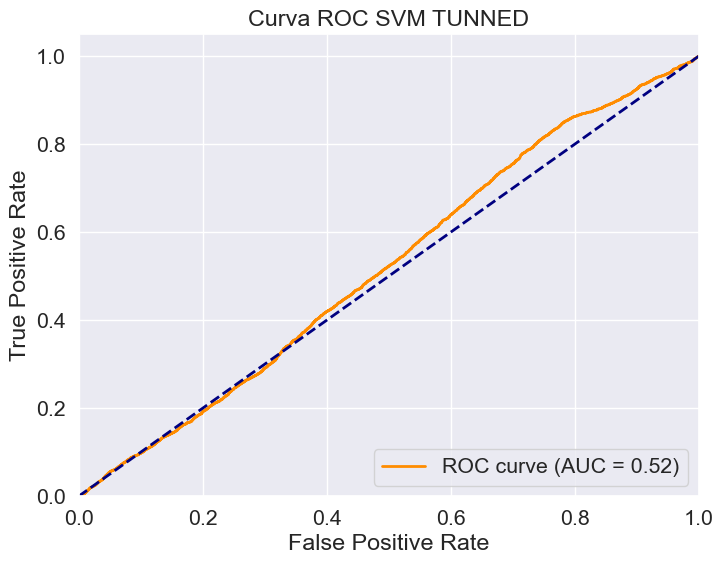

In [177]:
# Obtén las probabilidades de predicción para la clase positiva
y_prob_SVM_t = best_svm_model.predict_proba(X_test_)[:, 1]
# Calcula la curva ROC y el área bajo la curva (AUC)
fpr_SVM, tpr_SVM, _ = roc_curve(y_test_, y_prob_SVM_t)
roc_auc_SVM = auc(fpr_SVM, tpr_SVM)

# Grafica la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_SVM, tpr_SVM, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_SVM)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC SVM TUNNED')
plt.legend(loc='lower right')
plt.show()

XGBOOST

In [70]:
xb_model.fit(X_train_,y_train_)
y_pred = xb_model.predict(X_test_)
y_probxb = xb_model.predict_proba(X_test_)[:, 1]
print(classification_report(y_test_,xb_model.predict(X_test_)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113961
           1       0.90      0.43      0.58      4147

    accuracy                           0.98    118108
   macro avg       0.94      0.71      0.79    118108
weighted avg       0.98      0.98      0.97    118108



In [71]:
aucxb = roc_auc_score(y_test_, y_probxb)
print("XGBOOST AUC-ROC Score:", aucxb)


XGBOOST AUC-ROC Score: 0.9283286192355811


In [90]:
# Definir la grilla de hiperparámetros que deseas explorar
param_grid_xb = {
    'n_estimators': [110, 130],  # Estimadores
    'learning_rate': [0.001, 0.1],  # alphas
    'max_depth': [3, 5, 10]
}

# Crear un modelo XGBoost
xb_model_gb = XGBClassifier(random_state=123)

# Crear un objeto GridSearchCV para buscar los mejores hiperparámetros
grid_search_xb = GridSearchCV(estimator=xb_model_gb, param_grid=param_grid_xb, cv=5, n_jobs=-1)

# Ajustar el modelo XGBoost utilizando Grid Search
grid_search_xb.fit(X_train_, y_train_)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=123, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.1], 'max_depth': [3, 5, 10],
                         'n_estimators': [110, 130]})

In [91]:
# Obtener el mejor modelo con los mejores hiperparámetros
best_xb_model = grid_search_xb.best_estimator_
print(best_xb_model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=130, n_jobs=None,
              num_parallel_tree=None, random_state=123, ...)


In [92]:
best_xb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=130, n_jobs=None,
              num_parallel_tree=None, random_state=123, ...)

In [93]:
# Imprimir el reporte de clasificación del mejor modelo en los datos de prueba
y_pred_xb_t = best_xb_model.predict(X_test_)
y_probXB = best_xb_model.predict_proba(X_test_)[:, 1]
print(classification_report(y_test_, y_pred_xb_t, digits=5))

              precision    recall  f1-score   support

           0    0.98167   0.99843   0.98998    113961
           1    0.91867   0.48758   0.63705      4147

    accuracy                        0.98049    118108
   macro avg    0.95017   0.74301   0.81351    118108
weighted avg    0.97945   0.98049   0.97758    118108



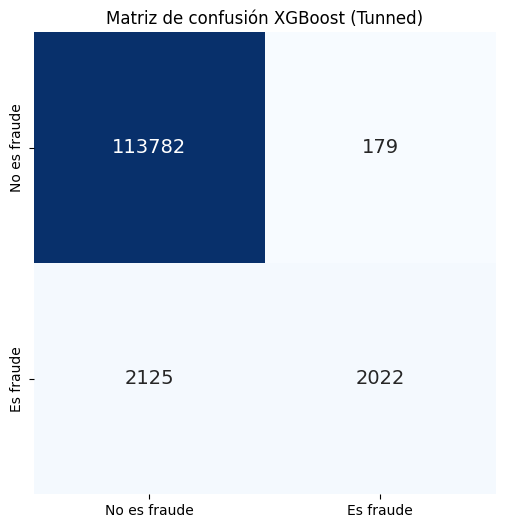

In [100]:
cm_xb_ = confusion_matrix(y_test_, y_pred_xb_t)
plt.figure(figsize=(8,6))
sns.heatmap(cm_xb_, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14}, square=True, xticklabels=["No es fraude", "Es fraude"], yticklabels=["No es fraude", "Es fraude"])
plt.title("Matriz de confusión XGBoost (Tunned)")
plt.show()

In [95]:
XBauc_score = roc_auc_score(y_test_, y_probXB)
print("KNN AUC-ROC Score:", XBauc_score)

KNN AUC-ROC Score: 0.9477680724041774


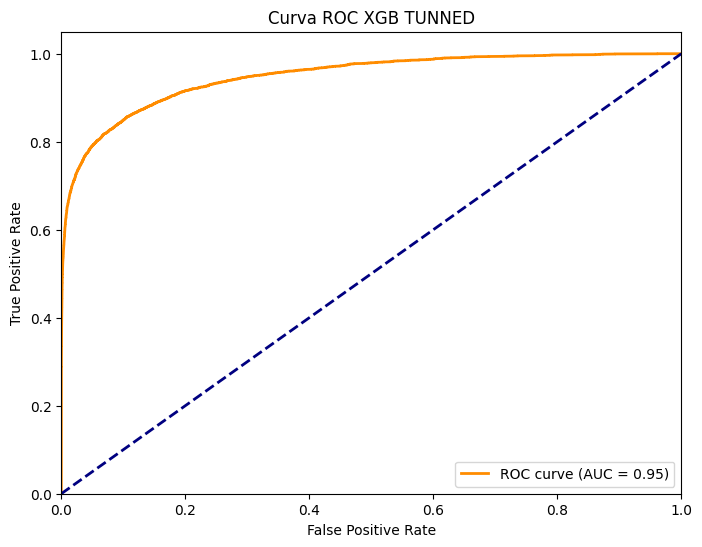

In [99]:
# Obtén las probabilidades de predicción para la clase positiva
y_prob_xb_t = best_xb_model.predict_proba(X_test_)[:, 1]
# Calcula la curva ROC y el área bajo la curva (AUC)
fpr_XB, tpr_XB, _ = roc_curve(y_test_, y_prob_xb_t)
roc_auc_XB = auc(fpr_XB, tpr_XB)

# Grafica la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_XB, tpr_XB, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_XB)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC XGB TUNNED')
plt.legend(loc='lower right')
plt.show()

MLP

In [72]:
mlp_classifier.fit(X_train_, y_train_)
y_pred = mlp_classifier.predict(X_test_)
y_probmlp = mlp_classifier.predict_proba(X_test_)[:, 1]
print(classification_report(y_test_,mlp_classifier.predict(X_test_)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    113961
           1       0.00      0.00      0.00      4147

    accuracy                           0.96    118108
   macro avg       0.48      0.50      0.49    118108
weighted avg       0.93      0.96      0.95    118108



In [73]:
mlp_score = roc_auc_score(y_test_, y_probmlp)
print("MLP AUC-ROC Score:", mlp_score)

MLP AUC-ROC Score: 0.5


In [193]:
# Crear una canalización (pipeline) con escalado y clasificador MLP
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Escalado de características
    ('mlp', MLPClassifier())       # Clasificador MLP
])

# Definir la grilla de hiperparámetros que deseas explorar para MLP y la canalización
param_grid = {
    'mlp__hidden_layer_sizes': [(10,10)],
    'mlp__activation': ['relu', 'logistic'],
    'mlp__alpha': [0.0001, 0.001, 0.01],
    'mlp__max_iter': [200],
}

# Crear un objeto GridSearchCV para buscar los mejores hiperparámetros en la canalización
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1)

# Ajustar la canalización con el clasificador MLP utilizando Grid Search
grid_search.fit(X_train_, y_train_)

# Obtener el mejor modelo con los mejores hiperparámetros
best_mlp_model = grid_search.best_estimator_
print(best_mlp_model)

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp', MLPClassifier(hidden_layer_sizes=(10, 10)))])


In [194]:
best_mlp_model = grid_search.best_estimator_
best_mlp_model

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp', MLPClassifier(hidden_layer_sizes=(10, 10)))])

In [198]:
best_mlp_model

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp', MLPClassifier(hidden_layer_sizes=(10, 10)))])

In [195]:
# Imprimir el reporte de clasificación del mejor modelo en los datos de prueba
y_pred_mlp_t = best_mlp_model.predict(X_test_)
y_probMLP = best_mlp_model.predict_proba(X_test_)[:, 1]
print(classification_report(y_test_, y_pred_mlp_t, digits=5))

              precision    recall  f1-score   support

           0    0.97567   0.99669   0.98607    113961
           1    0.77719   0.31710   0.45042      4147

    accuracy                        0.97283    118108
   macro avg    0.87643   0.65689   0.71825    118108
weighted avg    0.96870   0.97283   0.96726    118108



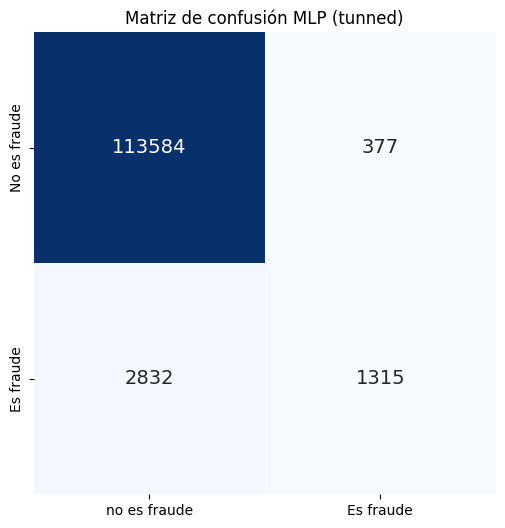

In [200]:
cm_mlp = confusion_matrix(y_test_, y_pred_mlp_t)
plt.figure(figsize=(8,6))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14}, square=True, xticklabels=["no es fraude", "Es fraude"], yticklabels=["No es fraude", "Es fraude"])
plt.title("Matriz de confusión MLP (tunned)")
plt.show()

In [201]:
MLPauc_score = roc_auc_score(y_test_, y_probMLP)
print("MLP tunned AUC-ROC Score:", MLPauc_score)

MLP tunned AUC-ROC Score: 0.8676742637072078


In [ ]:
# Obtén las probabilidades de predicción para la clase positiva
y_prob_MLP_t = best_svm_model.predict_proba(X_test_)[:, 1]
# Calcula la curva ROC y el área bajo la curva (AUC)
fpr_MLP, tpr_MLP, _ = roc_curve(y_test_, y_prob_MLP_t)
roc_auc_MLP = auc(fpr_MLP, tpr_MLP)

# Grafica la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_MLP, tpr_MLP, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_SVM)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC MLP TUNNED')
plt.legend(loc='lower right')
plt.show()

KNN

In [159]:
# Definir la grilla de hiperparámetros que deseas explorar

knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Agrega un escalador si es necesario
    ('knn', KNeighborsClassifier())
])

param_grid_knn = {
    'n_neighbors':[3, 5, 11, 17],  # n vecinos 
    'weights': ['uniform','distance'],  
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Crear un modelo KNN
knn_model_ = KNeighborsClassifier()

# Crear un objeto GridSearchCV para buscar los mejores hiperparámetros
grid_search_knn = GridSearchCV(estimator=knn_pipeline, param_grid=param_grid_knn, cv=5, n_jobs=-1, verbose=2)

# Ajustar el modelo SVM utilizando Grid Search
grid_search_knn.fit(X_train_, y_train_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 5, 11, 17],
                         'weights': ['uniform', 'distance']},
             verbose=2)

In [160]:
best_knn_model = grid_search_knn.best_estimator_
print(best_knn_model)

KNeighborsClassifier(n_neighbors=11, weights='distance')


In [161]:
y_pred_knn_t = best_knn_model.predict(X_test_)
y_probknn = best_knn_model.predict_proba(X_test_)[:, 1]
print(classification_report(y_test_,y_pred_knn_t, digits=5))

              precision    recall  f1-score   support

           0    0.97267   0.99808   0.98521    113961
           1    0.81282   0.22932   0.35772      4147

    accuracy                        0.97109    118108
   macro avg    0.89274   0.61370   0.67147    118108
weighted avg    0.96706   0.97109   0.96318    118108



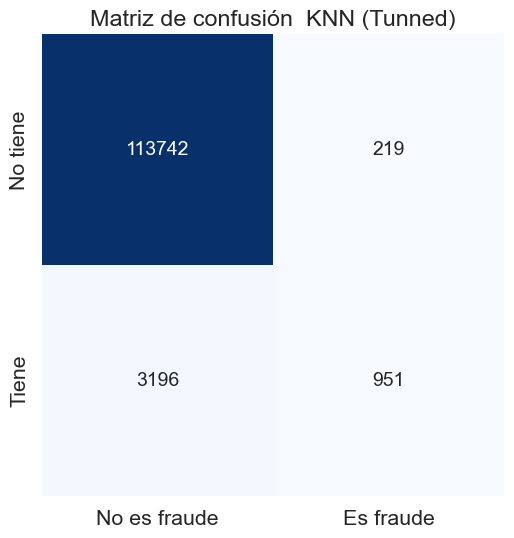

In [162]:
cm_knn_ = confusion_matrix(y_test_, y_pred_knn_t)
plt.figure(figsize=(8,6))
sns.heatmap(cm_knn_, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14}, square=True, xticklabels=["No es fraude", "Es fraude"], yticklabels=["No tiene", "Tiene"])
plt.title("Matriz de confusión  KNN (Tunned)")
plt.show()

In [163]:
KNNauc_score = roc_auc_score(y_test_, y_probknn)
print("KNN AUC-ROC Score:", KNNauc_score)

KNN AUC-ROC Score: 0.7440888768171331


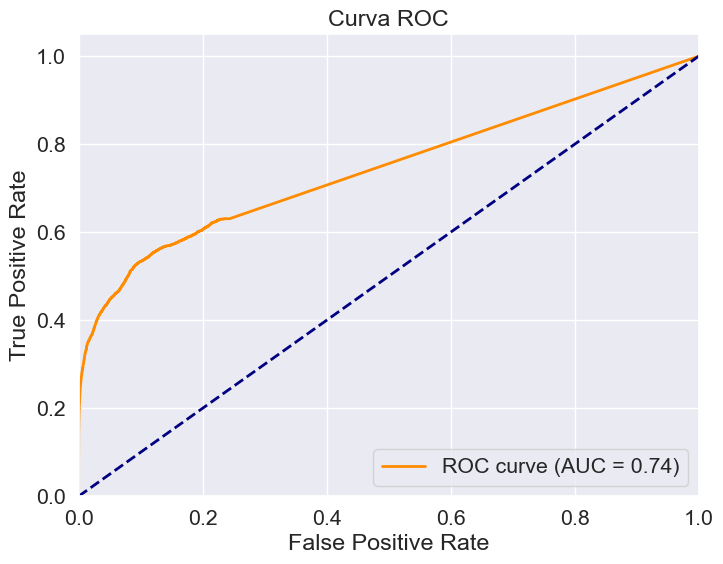

In [164]:
# Obtén las probabilidades de predicción para la clase positiva
y_prob_knn_t = best_knn_model.predict_proba(X_test_)[:, 1]
# Calcula la curva ROC y el área bajo la curva (AUC)
fpr_knn, tpr_knn, _ = roc_curve(y_test_, y_prob_knn_t)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Grafica la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_knn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

In [74]:
knn_model.fit(X_train_,y_train_)
y_pred = knn_model.predict(X_test_)
y_probknn = knn_model.predict_proba(X_test_)[:, 1]
print(classification_report(y_test_,knn_model.predict(X_test_)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98    113961
           1       0.44      0.13      0.20      4147

    accuracy                           0.96    118108
   macro avg       0.71      0.56      0.59    118108
weighted avg       0.95      0.96      0.95    118108



In [75]:
KNNauc_score = roc_auc_score(y_test_, y_probknn)
print("KNN AUC-ROC Score:", KNNauc_score)

KNN AUC-ROC Score: 0.7219557311907417


Naive Bayes

In [76]:
nb_model.fit(X_train_,y_train_)
y_pred = nb_model.predict(X_test_)
y_probNB = nb_model.predict_proba(X_test_)[:, 1]
print(classification_report(y_test_,nb_model.predict(X_test_)))

              precision    recall  f1-score   support

           0       0.98      0.43      0.59    113961
           1       0.05      0.80      0.09      4147

    accuracy                           0.44    118108
   macro avg       0.52      0.62      0.34    118108
weighted avg       0.95      0.44      0.58    118108



In [77]:
nbauc_score = roc_auc_score(y_test_, y_probNB)
print("NB AUC-ROC Score:", nbauc_score)


NB AUC-ROC Score: 0.7098196799764396


In [102]:
# Definir la grilla de hiperparámetros que deseas explorar
param_grid_nb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

# Crear un modelo NB
nb_model_ = GaussianNB()

# Crear un objeto GridSearchCV para buscar los mejores hiperparámetros
grid_search_nb = GridSearchCV(estimator=nb_model_, param_grid=param_grid_nb, cv=5, n_jobs=-1, verbose=2)

# Ajustar el modelo SVM utilizando Grid Search
grid_search_nb.fit(X_train_, y_train_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06]},
             verbose=2)

In [103]:
# Obtener el mejor modelo con los mejores hiperparámetros
best_nb_model = grid_search_nb.best_estimator_
print(best_nb_model)

GaussianNB(var_smoothing=1e-06)


In [104]:
best_nb_model

GaussianNB(var_smoothing=1e-06)

In [105]:
GaussianNB(var_smoothing=1e-06)

GaussianNB(var_smoothing=1e-06)

In [106]:
y_pred_nb_t = best_nb_model.predict(X_test_)
y_probNB = best_nb_model.predict_proba(X_test_)[:, 1]
print(classification_report(y_test_,y_pred_nb_t, digits=5))

              precision    recall  f1-score   support

           0    0.96612   0.98175   0.97387    113961
           1    0.09722   0.05401   0.06945      4147

    accuracy                        0.94917    118108
   macro avg    0.53167   0.51788   0.52166    118108
weighted avg    0.93561   0.94917   0.94212    118108



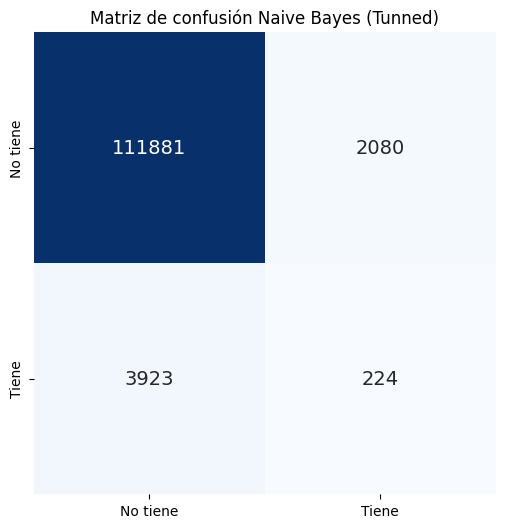

In [107]:
cm_nb_ = confusion_matrix(y_test_, y_pred_nb_t)
plt.figure(figsize=(8,6))
sns.heatmap(cm_nb_, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14}, square=True, xticklabels=["No tiene", "Tiene"], yticklabels=["No tiene", "Tiene"])
plt.title("Matriz de confusión Naive Bayes (Tunned)")
plt.show()

In [108]:
NBauc_score = roc_auc_score(y_test_, y_probNB)
print("Naive Bayes AUC-ROC Score:", NBauc_score)

Naive Bayes AUC-ROC Score: 0.6505553872688545


In [188]:
# Obtén las probabilidades de predicción para la clase positiva
y_prob_NB_t = best_svm_model.predict_proba(X_test_)[:, 1]
# Calcula la curva ROC y el área bajo la curva (AUC)
fpr_NB, tpr_NB, _ = roc_curve(y_test_, y_prob_NB_t)
roc_auc_SVM = auc(fpr_NB, tpr_SVM)

# Grafica la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_NB, tpr_NB, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_SVM)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC NB TUNNED')
plt.legend(loc='lower right')
plt.show()

LASSO

Como tal lasso da error al realizar la tabla de clasificacion, el roc curve y el auc al utilizarse en un problema de clasificacion, por lo cual usamos logistic regresion que comparte ciertas caracteristicas con lasso

In [111]:
lasso_classifier.fit(X_train_,y_train_)
y_pred = lasso_classifier.predict(X_test_)
y_probLA = lasso_classifier.predict_proba(X_test_)[:, 1]
print(classification_report(y_test_,lasso_classifier.predict(X_test_)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    113961
           1       0.78      0.11      0.20      4147

    accuracy                           0.97    118108
   macro avg       0.87      0.56      0.59    118108
weighted avg       0.96      0.97      0.96    118108



In [112]:
laauc_score = roc_auc_score(y_test_, y_probLA)
print("Lasso AUC-ROC Score:", laauc_score)

Lasso AUC-ROC Score: 0.8057411189834895


Gridsearch para lasso

In [150]:
param_grid = {
    'C': [0.1, 1.0, 10.0],  # Inversa de la fuerza de regularización
    'fit_intercept': [True, False],  # Opción para ajustar la intercepción
}

# Crear un modelo de regresión logística
logistic_model = LogisticRegression()

# Crear un objeto GridSearchCV para buscar los mejores hiperparámetros
grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, cv=5, n_jobs=-1)

# Ajustar el modelo de regresión logística utilizando Grid Search
grid_search.fit(X_train_, y_train_)

# Obtener el mejor modelo con los mejores hiperparámetros
best_logistic_model = grid_search.best_estimator_
print(best_logistic_model)

# Imprimir el reporte de clasificación del mejor modelo en los datos de prueba
y_pred_logistic_t = best_logistic_model.predict(X_test_)
print(classification_report(y_test_, y_pred_logistic_t, digits=5))

LogisticRegression(C=0.1)
              precision    recall  f1-score   support

           0    0.96489   0.99982   0.98205    113961
           1    0.04762   0.00024   0.00048      4147

    accuracy                        0.96473    118108
   macro avg    0.50625   0.50003   0.49126    118108
weighted avg    0.93268   0.96473   0.94758    118108



In [151]:
best_logistic_model

LogisticRegression(C=0.1)

In [156]:
cm_LR = confusion_matrix(y_test_, y_pred_logistic_t)
plt.figure(figsize=(8,6))
sns.heatmap(cm_LR, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14}, square=True, xticklabels=["no es fraude", "es fraude"], yticklabels=["no es fraude", "es fraude"])
plt.title("Matriz de confusión logistic regresion (tunned)")
plt.show()

In [157]:
lry_scores = best_logistic_model.decision_function(X_test_)

In [159]:
fprlr, tprlr, _ = roc_curve(y_test_, y_scores)
roc_auc = auc(fprlr, tprlr)

In [160]:
plt.figure(figsize=(8, 6))
plt.plot(fprlr, tprlr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC logistic (Tunned)')
plt.legend(loc='lower right')
plt.show()

## Ridge

In [120]:

# Supongamos que tienes X_train_, y_train_, X_test_, y_test_ definidos previamente

# Definir la grilla de hiperparámetros que deseas explorar para RidgeClassifier
param_grid = {
    'alpha': [0.1, 1.0, 10.0],  # Valores de regularización
    'solver': ['auto', 'svd', 'cholesky'],
    'max_iter': [50, 100]
}

# Crear un modelo RidgeClassifier
ridge_model = RidgeClassifier()

# Crear un objeto GridSearchCV para buscar los mejores hiperparámetros
grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, cv=5, n_jobs=-1)

# Ajustar el modelo RidgeClassifier utilizando Grid Search
grid_search.fit(X_train_, y_train_)

# Obtener el mejor modelo con los mejores hiperparámetros
best_ridge_model = grid_search.best_estimator_
print(best_ridge_model)

# Imprimir el reporte de clasificación del mejor modelo en los datos de prueba
y_pred_ridge_t = best_ridge_model.predict(X_test_)
print(classification_report(y_test_, y_pred_ridge_t, digits=5))


RidgeClassifier(alpha=0.1, max_iter=50)
              precision    recall  f1-score   support

           0    0.96654   0.99968   0.98283    113961
           1    0.84937   0.04895   0.09257      4147

    accuracy                        0.96630    118108
   macro avg    0.90796   0.52432   0.53770    118108
weighted avg    0.96243   0.96630   0.95157    118108



In [124]:
best_ridge_model = grid_search.best_estimator_
print(best_ridge_model)


RidgeClassifier(alpha=0.1, max_iter=50)


In [154]:
cm_ridge = confusion_matrix(y_test_, y_pred_ridge_t)
plt.figure(figsize=(8,6))
sns.heatmap(cm_ridge, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14}, square=True, xticklabels=["No es fraude", "es fraude"], yticklabels=["No es fraude", "es fraude"])
plt.title("Matriz de confusión ridge (tunned)")
plt.show()

In [130]:
y_scores = best_ridge_model.decision_function(X_test_)

In [131]:
fpr, tpr, _ = roc_curve(y_test_, y_scores)
roc_auc = auc(fpr, tpr)

In [132]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC RidgeClassifier (Tunned)')
plt.legend(loc='lower right')
plt.show()

En este ejercicio, el modelo de clasificación que tuvo mejor precisión, recall, f1-score,AUC y curva roc tanto en tunning como sin tunning fue el modelo de xgboost, mientras tanto, los modelos que tuvieron los valores más bajos fueron SVM Y MLP pero estos tienen su respectiva justificación pues debido al alto gasto computacional tuve que limitar el número de interacciones en el caso de SVM y el número de nodos en MLP, estos algoritmos con valores más altos llegaron a durar más de 2 horas sin llegar a acabar, por lo cual les puse parámetros más bajos, e igualmente duraron cierto tiempo, svm duró más de dos horas sin terminar, no teniendo un máximo número de interacción y con el tunning, llegado a durar 30 minutos y suport vector machine durando 20, a pesar del manejo de los parámetros, estos modelos pasaron de tener puntuaciones bajas, a pasar a tener ciertas mejoras, en el caso de svm, las mejoras fueron muy poco notorias, pero el MLP paso de tener un valores de puntuación de 0 a pasar de tener valores  mucho más altos, por ejemplo, paso a tener un precisión de 0.7, un recal de 0,31, un f1 score de 0.45, y un AUC original de 0.5, que tras pasar por el tunning de grid search paso a temer un AUC de 0.86, con un mayor número de nodos y otros parámetros puede que mejoren todos los modelos de manera significativa.

De manera general, a diferencia del SVM, el resto de modelos ejecutados tuvieron una mejora significativa al aplicar el gridsearch, se utilizo linear regresor en vez de utilizar lasso debido a que este producia un error al crear los parametros de clasificacion, el auc y la curva de roc, diria que una mejor limpieza de datos, como un mejor manejo de las variable extensas denomindas 'Cxx', 'dxx'. 'M' y sobre todo 'Vxx' ayudaria tambien a mejorar las puntuaciones de los modelos, pues estas variables se encontraban en su gran mayoria vacias, ademas que la eliminacion de mas de 300 variables tambien afecto negativamente al modelo


ahora seria realizar el analisis exploratoria del segundo dataset, el relacionado a windspeed


## Punto modelo de regresion de velocidad del viento

In [5]:
wind= pd.read_csv('C:/Users/crist/OneDrive/Escritorio/parcialmachinelearning/wind speed/data_treino_dv_df_2000_2010.csv')

In [6]:
wind

HORA (UTC)  VENTO, DIREï¿½ï¿½O HORARIA (gr) (ï¿½ (gr))  \
0          12:00                                    0.809017   
1          13:00                                    0.965926   
2          14:00                                    0.891007   
3          15:00                                    0.848048   
4          16:00                                    0.224951   
...          ...                                         ...   
87688      19:00                                   -0.615661   
87689      20:00                                   -0.469472   
87690      21:00                                   -0.484810   
87691      22:00                                   -0.484810   
87692      23:00                                   -0.573576   

       VENTO, VELOCIDADE HORARIA (m/s)  \
0                                  1.8   
1                                  2.7   
2                                  2.0   
3                                  2.5   
4                                  2.4   
...                                ...   
87688                              5.6   
87689                              4.9   
87690                              4.5   
87691                              3.2   
87692                              2.3   

       UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)  \
0                                          69.0   
1                                          62.0   
2                                          56.0   
3                                          52.0   
4                                          50.0   
...                                         ...   
87688                                      83.0   
87689                                      84.0   
87690                                      86.0   
87691                                      88.0   
87692                                      95.0   

       UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)  \
0                                          60.0   
1                                          55.0   
2                                          50.0   
3                                          44.0   
4                                          43.0   
...                                         ...   
87688                                      78.0   
87689                                      79.0   
87690                                      82.0   
87691                                      85.0   
87692                                      88.0   

       TEMPERATURA Mï¿½XIMA NA HORA ANT. (AUT) (ï¿½C)  \
0                                                22.6   
1                                                24.2   
2                                                25.5   
3                                                27.4   
4                                                27.1   
...                                               ...   
87688                                            21.8   
87689                                            21.7   
87690                                            21.2   
87691                                            20.6   
87692                                            20.2   

       TEMPERATURA Mï¿½NIMA NA HORA ANT. (AUT) (ï¿½C)  \
0                                                20.7   
1                                                22.5   
2                                                24.3   
3                                                25.0   
4                                                25.5   
...                                               ...   
87688                                            21.1   
87689                                            21.0   
87690                                            20.6   
87691                                            20.2   
87692                                            19.3   

       UMIDADE RELATIVA DO AR, HORARIA (%)  \
0                                     61.0   
1                                     55.0  

se puede observar que el dataset tiene originalmente 13 columnas y 87693 filas

In [7]:
print(wind.columns.values)

['HORA (UTC)' 'VENTO, DIREï¿½ï¿½O HORARIA (gr) (ï¿½ (gr))'
 'VENTO, VELOCIDADE HORARIA (m/s)'
 'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)'
 'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)'
 'TEMPERATURA Mï¿½XIMA NA HORA ANT. (AUT) (ï¿½C)'
 'TEMPERATURA Mï¿½NIMA NA HORA ANT. (AUT) (ï¿½C)'
 'UMIDADE RELATIVA DO AR, HORARIA (%)'
 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)'
 'PRECIPITAï¿½ï¿½O TOTAL, HORï¿½RIO (mm)' 'VENTO, RAJADA MAXIMA (m/s)'
 'PRESSï¿½O ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)'
 'PRESSï¿½O ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)']


se puede notar que el lenguaje utilizado en el dataset es extenso y no es español, por lo cual estaria bien realizar un renombre de columnas mas adelante

In [8]:
wind.head()

HORA (UTC)  VENTO, DIREï¿½ï¿½O HORARIA (gr) (ï¿½ (gr))  \
0      12:00                                    0.809017   
1      13:00                                    0.965926   
2      14:00                                    0.891007   
3      15:00                                    0.848048   
4      16:00                                    0.224951   

   VENTO, VELOCIDADE HORARIA (m/s)  UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)  \
0                              1.8                                      69.0   
1                              2.7                                      62.0   
2                              2.0                                      56.0   
3                              2.5                                      52.0   
4                              2.4                                      50.0   

   UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)  \
0                                      60.0   
1                                      55.0   
2                                      50.0   
3                                      44.0   
4                                      43.0   

   TEMPERATURA Mï¿½XIMA NA HORA ANT. (AUT) (ï¿½C)  \
0                                            22.6   
1                                            24.2   
2                                            25.5   
3                                            27.4   
4                                            27.1   

   TEMPERATURA Mï¿½NIMA NA HORA ANT. (AUT) (ï¿½C)  \
0                                            20.7   
1                                            22.5   
2                                            24.3   
3                                            25.0   
4                                            25.5   

   UMIDADE RELATIVA DO AR, HORARIA (%)  \
0                                 61.0   
1                                 55.0   
2                                 51.0   
3                                 44.0   
4                                 46.0   

   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  \
0                                              888.2       
1                                              888.4       
2                                              888.1       
3                                              887.4       
4                                              886.5       

   PRECIPITAï¿½ï¿½O TOTAL, HORï¿½RIO (mm)  VENTO, RAJADA MAXIMA (m/s)  \
0                                     0.0                         3.8   
1                                     0.0                         4.7   
2                                     0.0                         4.9   
3                                     0.0                         5.8   
4                                     0.0                         5.8   

   PRESSï¿½O ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)  \
0                                              888.2   
1                                              888.4   
2                                              888.4   
3                                              888.1   
4                                              887.4   

   PRESSï¿½O ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)  
0                                              887.7   
1                                              888.2   
2                                              888.1   
3                                              887.4   
4                                              886.5

por ahora no se observan datos vacios

In [9]:
wind['HORA (UTC)'] = wind['HORA (UTC)'].str.replace(r':\d+', '', regex=True)

In [10]:
wind.head()

HORA (UTC)  VENTO, DIREï¿½ï¿½O HORARIA (gr) (ï¿½ (gr))  \
0         12                                    0.809017   
1         13                                    0.965926   
2         14                                    0.891007   
3         15                                    0.848048   
4         16                                    0.224951   

   VENTO, VELOCIDADE HORARIA (m/s)  UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)  \
0                              1.8                                      69.0   
1                              2.7                                      62.0   
2                              2.0                                      56.0   
3                              2.5                                      52.0   
4                              2.4                                      50.0   

   UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)  \
0                                      60.0   
1                                      55.0   
2                                      50.0   
3                                      44.0   
4                                      43.0   

   TEMPERATURA Mï¿½XIMA NA HORA ANT. (AUT) (ï¿½C)  \
0                                            22.6   
1                                            24.2   
2                                            25.5   
3                                            27.4   
4                                            27.1   

   TEMPERATURA Mï¿½NIMA NA HORA ANT. (AUT) (ï¿½C)  \
0                                            20.7   
1                                            22.5   
2                                            24.3   
3                                            25.0   
4                                            25.5   

   UMIDADE RELATIVA DO AR, HORARIA (%)  \
0                                 61.0   
1                                 55.0   
2                                 51.0   
3                                 44.0   
4                                 46.0   

   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  \
0                                              888.2       
1                                              888.4       
2                                              888.1       
3                                              887.4       
4                                              886.5       

   PRECIPITAï¿½ï¿½O TOTAL, HORï¿½RIO (mm)  VENTO, RAJADA MAXIMA (m/s)  \
0                                     0.0                         3.8   
1                                     0.0                         4.7   
2                                     0.0                         4.9   
3                                     0.0                         5.8   
4                                     0.0                         5.8   

   PRESSï¿½O ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)  \
0                                              888.2   
1                                              888.4   
2                                              888.4   
3                                              888.1   
4                                              887.4   

   PRESSï¿½O ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)  
0                                              887.7   
1                                              888.2   
2                                              888.1   
3                                              887.4   
4                                              886.5

con este condigo cambiamos el formato de hora para que solo nos muestre la hora y no los minutos

In [11]:
wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87693 entries, 0 to 87692
Data columns (total 13 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   HORA (UTC)                                             87693 non-null  object 
 1   VENTO, DIREï¿½ï¿½O HORARIA (gr) (ï¿½ (gr))             87693 non-null  float64
 2   VENTO, VELOCIDADE HORARIA (m/s)                        87693 non-null  float64
 3   UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)               87693 non-null  float64
 4   UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)               87693 non-null  float64
 5   TEMPERATURA Mï¿½XIMA NA HORA ANT. (AUT) (ï¿½C)         87693 non-null  float64
 6   TEMPERATURA Mï¿½NIMA NA HORA ANT. (AUT) (ï¿½C)         87693 non-null  float64
 7   UMIDADE RELATIVA DO AR, HORARIA (%)                    87693 non-null  float64
 8   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORAR

en este caso se puede ver que todas las variables son numericas a excepcion de hora, en este caso la convertiremos en float

In [12]:
wind['HORA (UTC)'] = wind['HORA (UTC)'].astype('float64')

In [13]:
wind.head()

HORA (UTC)  VENTO, DIREï¿½ï¿½O HORARIA (gr) (ï¿½ (gr))  \
0        12.0                                    0.809017   
1        13.0                                    0.965926   
2        14.0                                    0.891007   
3        15.0                                    0.848048   
4        16.0                                    0.224951   

   VENTO, VELOCIDADE HORARIA (m/s)  UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)  \
0                              1.8                                      69.0   
1                              2.7                                      62.0   
2                              2.0                                      56.0   
3                              2.5                                      52.0   
4                              2.4                                      50.0   

   UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)  \
0                                      60.0   
1                                      55.0   
2                                      50.0   
3                                      44.0   
4                                      43.0   

   TEMPERATURA Mï¿½XIMA NA HORA ANT. (AUT) (ï¿½C)  \
0                                            22.6   
1                                            24.2   
2                                            25.5   
3                                            27.4   
4                                            27.1   

   TEMPERATURA Mï¿½NIMA NA HORA ANT. (AUT) (ï¿½C)  \
0                                            20.7   
1                                            22.5   
2                                            24.3   
3                                            25.0   
4                                            25.5   

   UMIDADE RELATIVA DO AR, HORARIA (%)  \
0                                 61.0   
1                                 55.0   
2                                 51.0   
3                                 44.0   
4                                 46.0   

   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  \
0                                              888.2       
1                                              888.4       
2                                              888.1       
3                                              887.4       
4                                              886.5       

   PRECIPITAï¿½ï¿½O TOTAL, HORï¿½RIO (mm)  VENTO, RAJADA MAXIMA (m/s)  \
0                                     0.0                         3.8   
1                                     0.0                         4.7   
2                                     0.0                         4.9   
3                                     0.0                         5.8   
4                                     0.0                         5.8   

   PRESSï¿½O ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)  \
0                                              888.2   
1                                              888.4   
2                                              888.4   
3                                              888.1   
4                                              887.4   

   PRESSï¿½O ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)  
0                                              887.7   
1                                              888.2   
2                                              888.1   
3                                              887.4   
4                                              886.5

ahora el objetivo seria ver si el dataset tiene datos vacios

In [14]:
wind.isnull().sum()

HORA (UTC)                                               0
VENTO, DIREï¿½ï¿½O HORARIA (gr) (ï¿½ (gr))               0
VENTO, VELOCIDADE HORARIA (m/s)                          0
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                 0
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)                 0
TEMPERATURA Mï¿½XIMA NA HORA ANT. (AUT) (ï¿½C)           0
TEMPERATURA Mï¿½NIMA NA HORA ANT. (AUT) (ï¿½C)           0
UMIDADE RELATIVA DO AR, HORARIA (%)                      0
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)    0
PRECIPITAï¿½ï¿½O TOTAL, HORï¿½RIO (mm)                   0
VENTO, RAJADA MAXIMA (m/s)                               0
PRESSï¿½O ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)        0
PRESSï¿½O ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)       0
dtype: int64

In [15]:
df_clean2 = wind.dropna()


In [16]:
print(df_clean2)

       HORA (UTC)  VENTO, DIREï¿½ï¿½O HORARIA (gr) (ï¿½ (gr))  \
0            12.0                                    0.809017   
1            13.0                                    0.965926   
2            14.0                                    0.891007   
3            15.0                                    0.848048   
4            16.0                                    0.224951   
...           ...                                         ...   
87688        19.0                                   -0.615661   
87689        20.0                                   -0.469472   
87690        21.0                                   -0.484810   
87691        22.0                                   -0.484810   
87692        23.0                                   -0.573576   

       VENTO, VELOCIDADE HORARIA (m/s)  \
0                                  1.8   
1                                  2.7   
2                                  2.0   
3                                  2.5   
4        

en este caso, a diferencia del dataset anterior, no existen datos vacios, pero debido a la forma que se llaman las columnas, seria mejor renombrarlas para un mejor manejo, como tambien una mejor graficacion

In [17]:
nombres_nuevos = {'HORA (UTC)': 'HORA','VENTO, DIREï¿½ï¿½O HORARIA (gr) (ï¿½ (gr))': 'Dirección del viento horaria',
                  'VENTO, VELOCIDADE HORARIA (m/s)': 'Velocidad horario del viento (m/s)', 
                  'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)': 'Humedad rel. máx aut',
                  'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)':'Humedad rel. mín aut',
                  'TEMPERATURA Mï¿½XIMA NA HORA ANT. (AUT) (ï¿½C)': 'Temperatura máx. AUT',
                  'TEMPERATURA Mï¿½NIMA NA HORA ANT. (AUT) (ï¿½C)': 'Temperatura mín. AUT',
                  'UMIDADE RELATIVA DO AR, HORARIA (%)':'Humedad relativa',
                  'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)':'Presión atmosférica',
                  'PRECIPITAï¿½ï¿½O TOTAL, HORï¿½RIO (mm)':' Precipitación total',
                  'PRESSï¿½O ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)': 'Presiatmosmax',
                  'VENTO, RAJADA MAXIMA (m/s)': 'Máxima ráfaga de viento',
                  'PRESSï¿½O ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)': 'Presión atmosférica mín.',}

In [18]:
wind.rename(columns=nombres_nuevos, inplace=True)
wind

HORA  Dirección del viento horaria  Velocidad horario del viento (m/s)  \
0      12.0                      0.809017                                 1.8   
1      13.0                      0.965926                                 2.7   
2      14.0                      0.891007                                 2.0   
3      15.0                      0.848048                                 2.5   
4      16.0                      0.224951                                 2.4   
...     ...                           ...                                 ...   
87688  19.0                     -0.615661                                 5.6   
87689  20.0                     -0.469472                                 4.9   
87690  21.0                     -0.484810                                 4.5   
87691  22.0                     -0.484810                                 3.2   
87692  23.0                     -0.573576                                 2.3   

       Humedad rel. máx aut  Humedad rel. mín aut  Temperatura máx. AUT  \
0                      69.0                  60.0                  22.6   
1                      62.0                  55.0                  24.2   
2                      56.0                  50.0                  25.5   
3                      52.0                  44.0                  27.4   
4                      50.0                  43.0                  27.1   
...                     ...                   ...                   ...   
87688                  83.0                  78.0                  21.8   
87689                  84.0                  79.0                  21.7   
87690                  86.0                  82.0                  21.2   
87691                  88.0                  85.0                  20.6   
87692                  95.0                  88.0                  20.2   

       Temperatura mín. AUT  Humedad relativa  Presión atmosférica  \
0                      20.7              61.0                888.2   
1                      22.5              55.0                888.4   
2                      24.3              51.0                888.1   
3                      25.0              44.0                887.4   
4                      25.5              46.0                886.5   
...                     ...               ...                  ...   
87688                  21.1              80.0                879.1   
87689                  21.0              84.0                879.2   
87690                  20.6              86.0                879.7   
87691                  20.2              88.0                880.5   
87692                  19.3              95.0                881.1   

        Precipitación total  Máxima ráfaga de viento  Presiatmosmax  \
0                       0.0                      3.8          888.2   
1                       0.0                      4.7          888.4   
2                       0.0                      4.9          888.4   
3                       0.0                      5.8          888.1   
4                       0.0                      5.8          887.4   
...                     ...                      ...            ...   
87688                   0.0                     12.3          879.8   
87689                   0.0                      9.9          879.2   
87690                   0.0                      8.9          879.8   
87691                   0.0                      8.0          880.5   
87692                   0.6                      7.5          881.1   

       Presión atmosférica mín.  
0                         887.7  
1                         888.2  
2                         888.1  
3                         887.4  
4                         886.5  
...                         ...  
87688                     879.1  
87689                     878.9  
87690                     879.2  
87691                     879.6  
87692                     880.5  

[87693 rows x 13 columns]

In [19]:
wind.describe().T

count        mean        std    min  \
HORA                                87693.0   11.506437   6.932300    0.0   
Dirección del viento horaria        87693.0    0.405810   0.686247   -1.0   
Velocidad horario del viento (m/s)  87693.0    2.466192   1.313968    0.0   
Humedad rel. máx aut                87693.0   69.058465  19.640222   12.0   
Humedad rel. mín aut                87693.0   63.176194  20.166336   10.0   
Temperatura máx. AUT                87693.0   21.921264   3.721386    9.2   
Temperatura mín. AUT                87693.0   20.684570   3.513744    8.4   
Humedad relativa                    87693.0   66.146682  19.992327   10.0   
Presión atmosférica                 87693.0  887.251925   4.012404  863.4   
 Precipitación total                87693.0    0.160907   1.307515    0.0   
Máxima ráfaga de viento             87693.0    5.161076   2.311157    0.0   
Presiatmosmax                       87693.0  887.580724   3.646750  865.3   
Presión atmosférica mín.            87693.0  886.891093   3.564539  862.8   

                                           25%         50%         75%     max  
HORA                                  5.000000   12.000000   18.000000    23.0  
Dirección del viento horaria         -0.156434    0.788011    0.970296     1.0  
Velocidad horario del viento (m/s)    1.500000    2.400000    3.400000    10.0  
Humedad rel. máx aut                 54.000000   72.000000   87.000000   100.0  
Humedad rel. mín aut                 48.000000   64.000000   80.000000    98.0  
Temperatura máx. AUT                 19.200000   21.400000   24.700000    35.3  
Temperatura mín. AUT                 18.400000   20.200000   23.100000    34.4  
Humedad relativa                     51.000000   68.000000   84.000000    99.0  
Presión atmosférica                 885.300000  887.200000  889.100000  1023.5  
 Precipitación total                  0.000000    0.000000    0.000000    70.8  
Máxima ráfaga de viento               3.400000    5.000000    6.800000    24.3  
Presiatmosmax                       885.600000  887.500000  889.300000   913.1  
Presión atmosférica mín.            885.000000  886.900000  888.800000   910.9

los datos ya parecen organizados

Column:  HORA
Skew: -0.0
Kurtosis:  -1.21


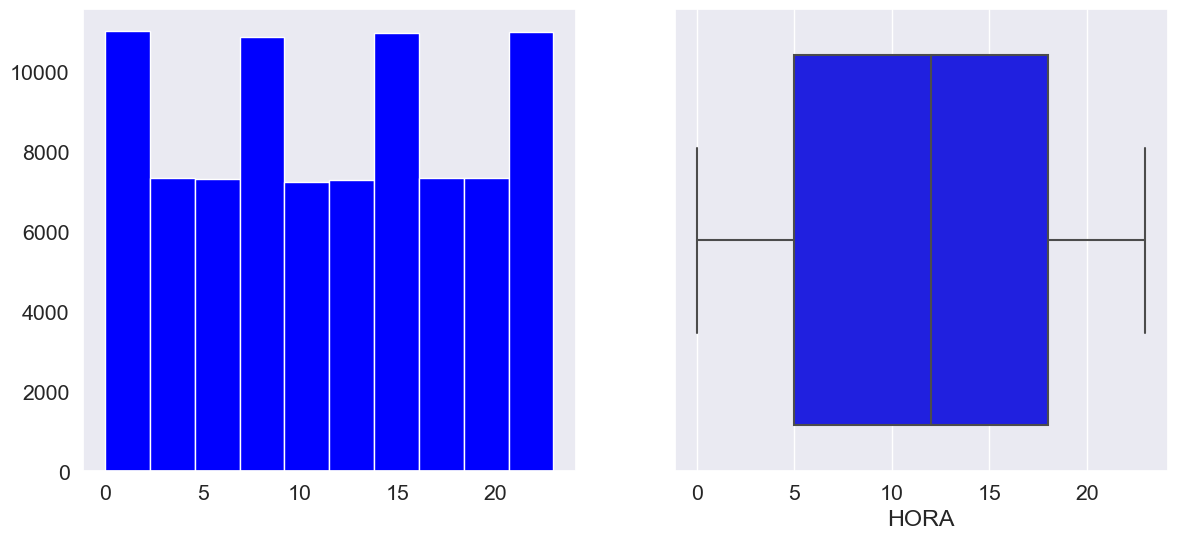

Column:  Dirección del viento horaria
Skew: -0.86
Kurtosis:  -0.82


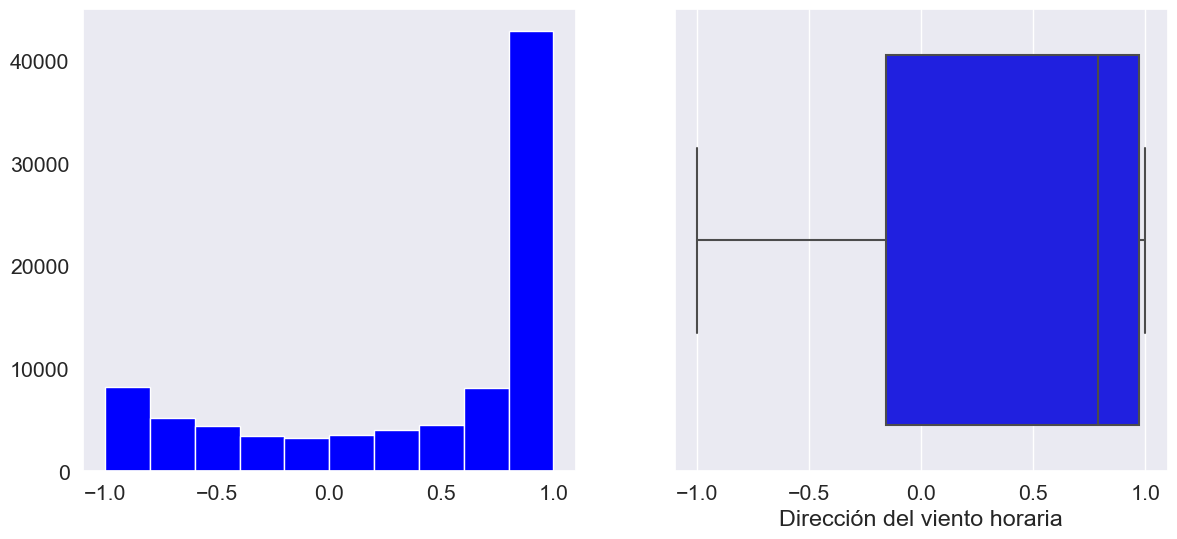

Column:  Velocidad horario del viento (m/s)
Skew: 0.37
Kurtosis:  -0.11


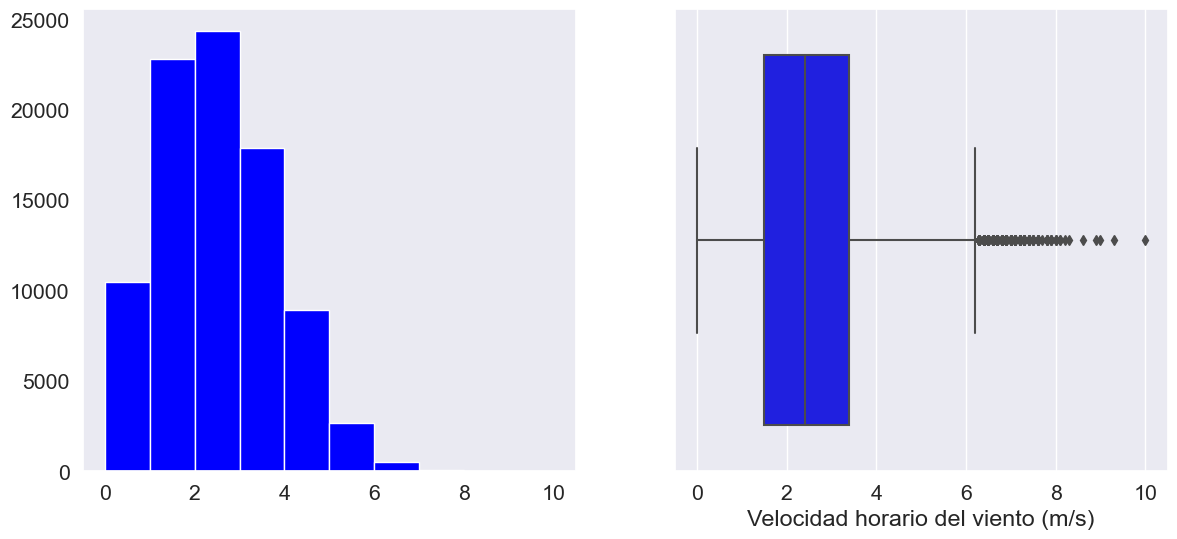

Column:  Humedad rel. máx aut
Skew: -0.48
Kurtosis:  -0.78


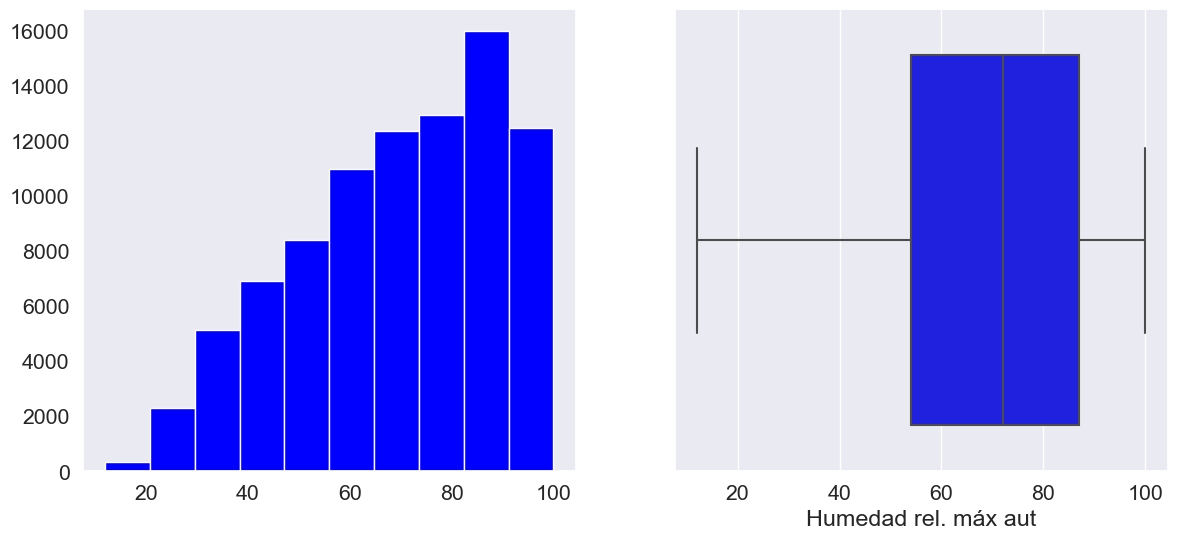

Column:  Humedad rel. mín aut
Skew: -0.23
Kurtosis:  -0.96


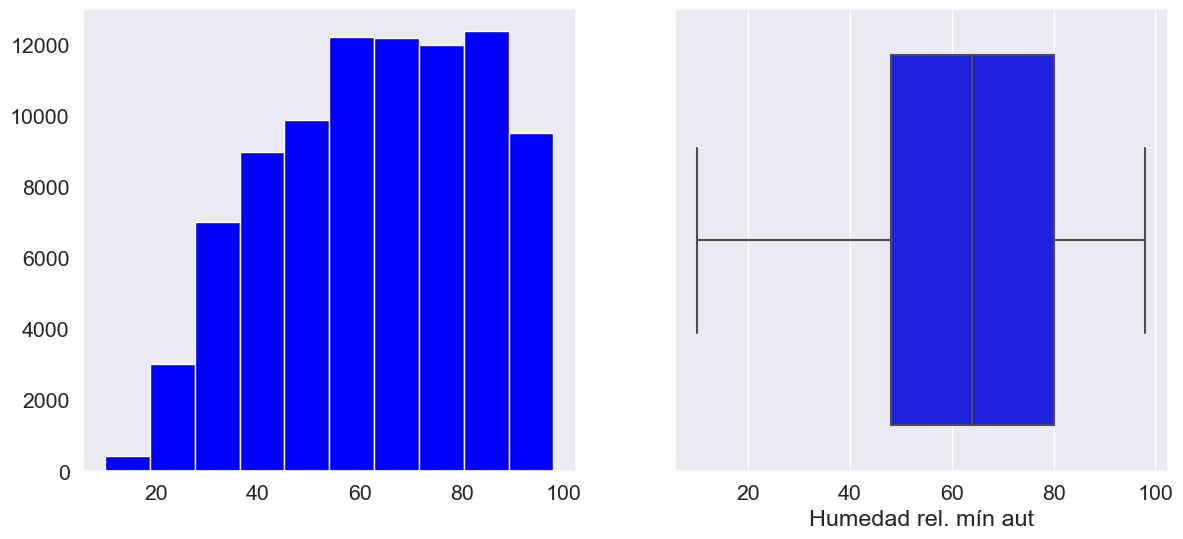

Column:  Temperatura máx. AUT
Skew: 0.26
Kurtosis:  -0.42


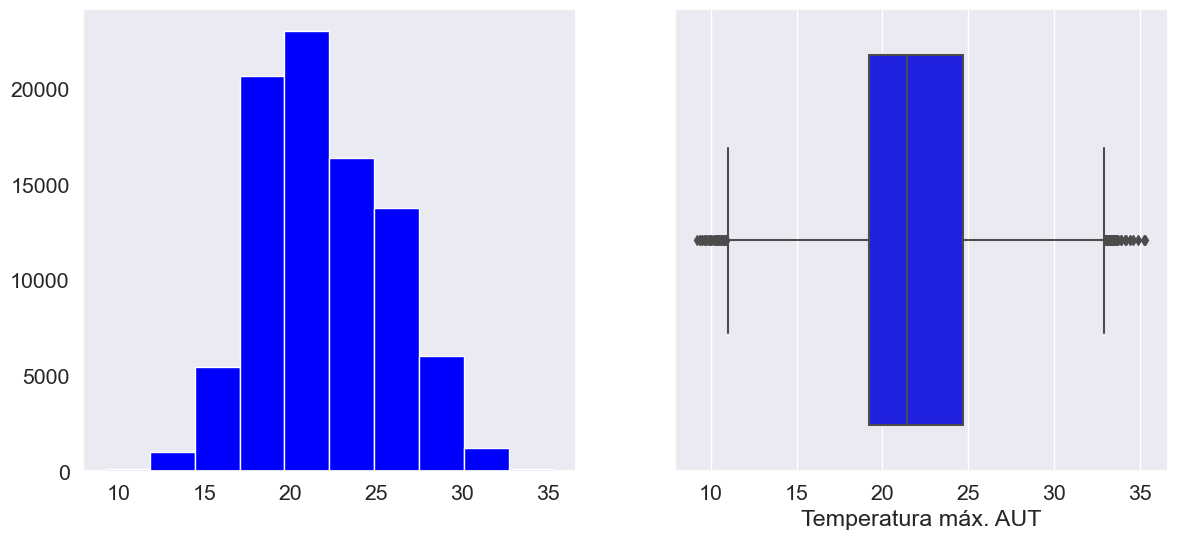

Column:  Temperatura mín. AUT
Skew: 0.24
Kurtosis:  -0.12


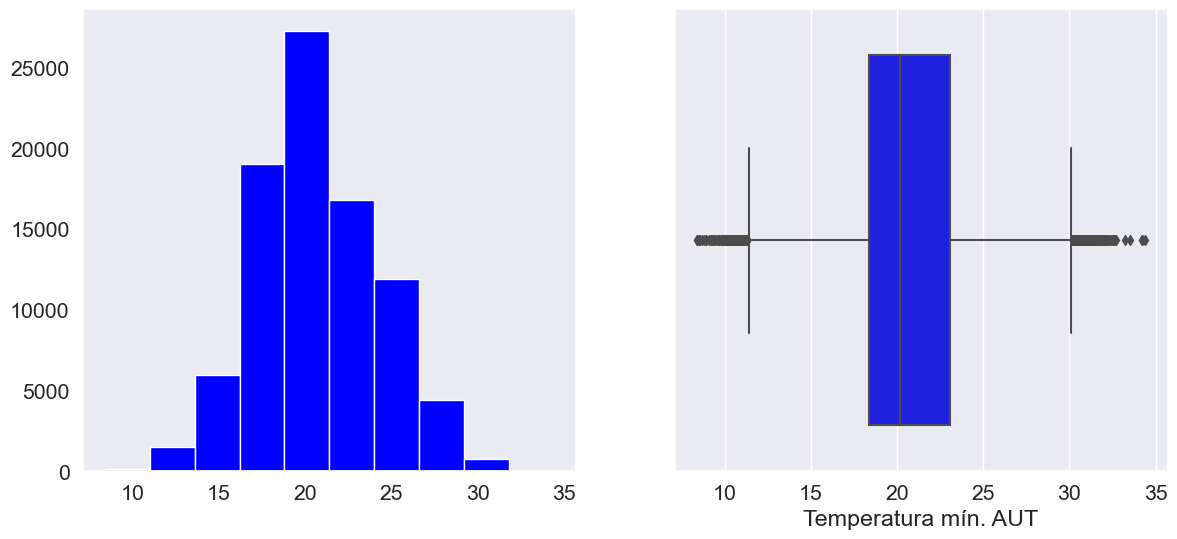

Column:  Humedad relativa
Skew: -0.35
Kurtosis:  -0.89


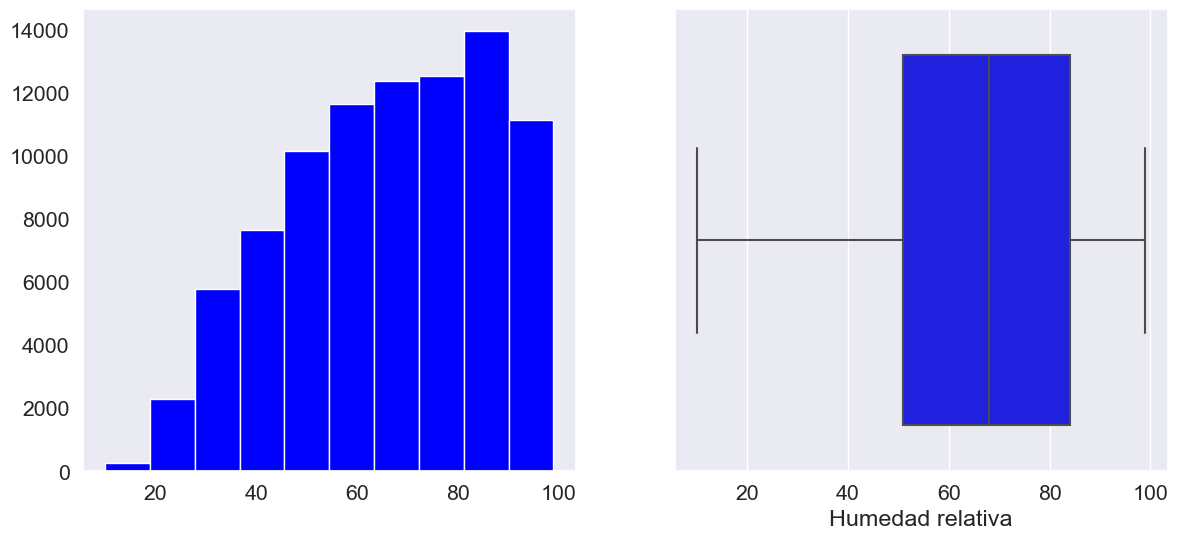

Column:  Presión atmosférica
Skew: 6.18
Kurtosis:  179.64


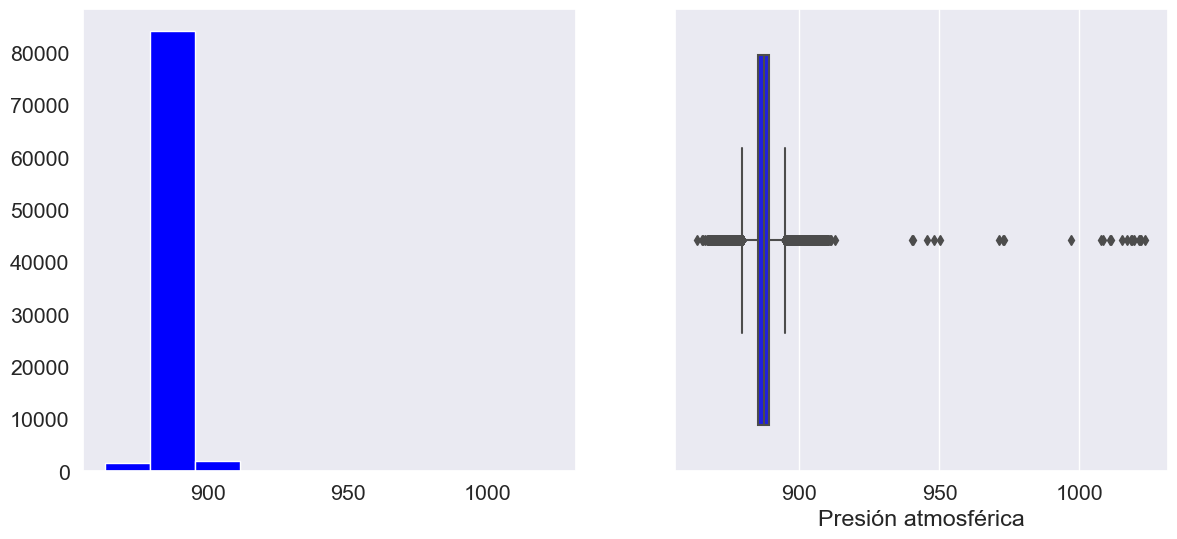

Column:   Precipitación total
Skew: 17.65
Kurtosis:  476.4


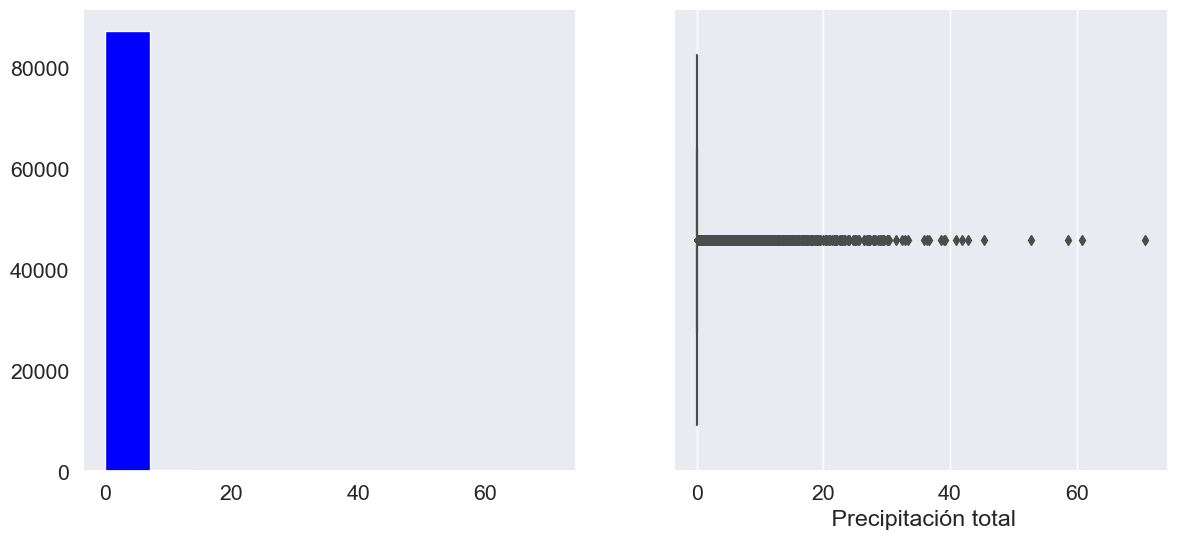

Column:  Máxima ráfaga de viento
Skew: 0.41
Kurtosis:  0.11


Column:  Presiatmosmax
Skew: 1.02
Kurtosis:  5.82


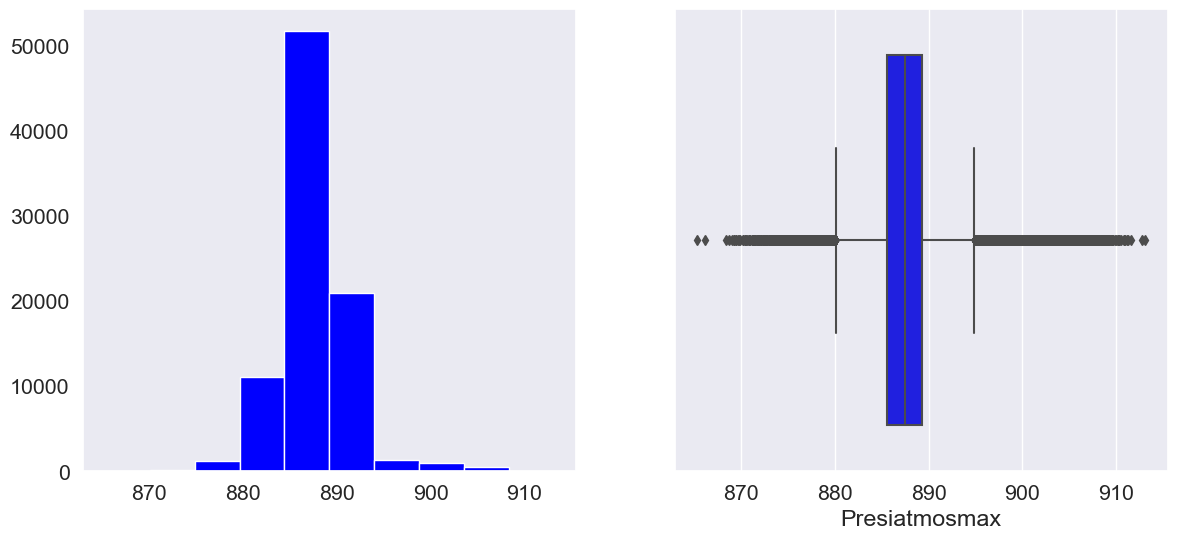

Column:  Presión atmosférica mín.
Skew: 0.33
Kurtosis:  4.91


In [20]:
num_cols = wind.select_dtypes(include=np.number).columns.tolist()
sns.set(font_scale=1.4)
color = 'blue'

for col in num_cols:
    print('Column: ', col)
    print('Skew:', round(wind[col].skew(), 2))
    print('Kurtosis: ', round(wind[col].kurtosis(), 2))
    plt.figure(figsize = (14, 6))
    plt.subplot(1, 2, 1)
    wind[col].hist(grid=False, color=color)
    plt.subplot(1, 2, 2)
    sns.boxplot(x=wind[col], color=color)
    plt.show()

Se podria decir que existen ciertos datos que se encuentran sesgados pero es normal en algunos en cierta debida debido a que se miden minimos y maximos en cada uno, en el caso de la direccion del viento (m/s) este tiene cierta tendencia a la derecha mientras que la velocidad del viento es a la izquierda, siendo velocidades poco fuerte y disfrutables para el ser humano. respecto a la humedad, se puede observar que la humedad relativa, la humedad min y max tienen cierta tendencia a la izquierda,  caso curioso teniendo en cuenta que deberian ser medidas opuestas pero terminan generando una alta correlacion en los datos, lo mismo sucede en el caso al evaluar tanto la temperatura o minima, en ambos casos estos datos dan a entender que los datos se mantuvieron en condiciones ambientales relativamente estables y constantes al momento de obtener dhicos datos, lo mismo sucede con la precion atmosferica, la precipitacion total, la rafaga maxima de viento y la presion atmosferica, siendo datos que se mantienen en niveles constantes en el tiempo.
De manera general, hay muchos datos con bastante correlacion y que se encuentran muy constantes, por lo cual seria importante realizar una limpieza de estos datos.

ahora realizamos un regplot bivariado de la velocidad horaria del viento con el resto de datos con el fin de conocer si existe cierta correlacion

In [21]:
def scatter_regplot(wind, strx, stry, scatter_color='blue', regplot_color='lightpink'):
    sns.set(font_scale=1.4)
    fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    sns.scatterplot(data=wind, x=strx, y=stry, ax=ax[0], color=scatter_color)  # Set scatterplot color
    sns.regplot(data=wind, x=strx, y=stry, ax=ax[1], color=regplot_color)  # Set regression plot color
    fig.suptitle('Relación entre %s y Velocidad horario del viento (m/s)' % col)




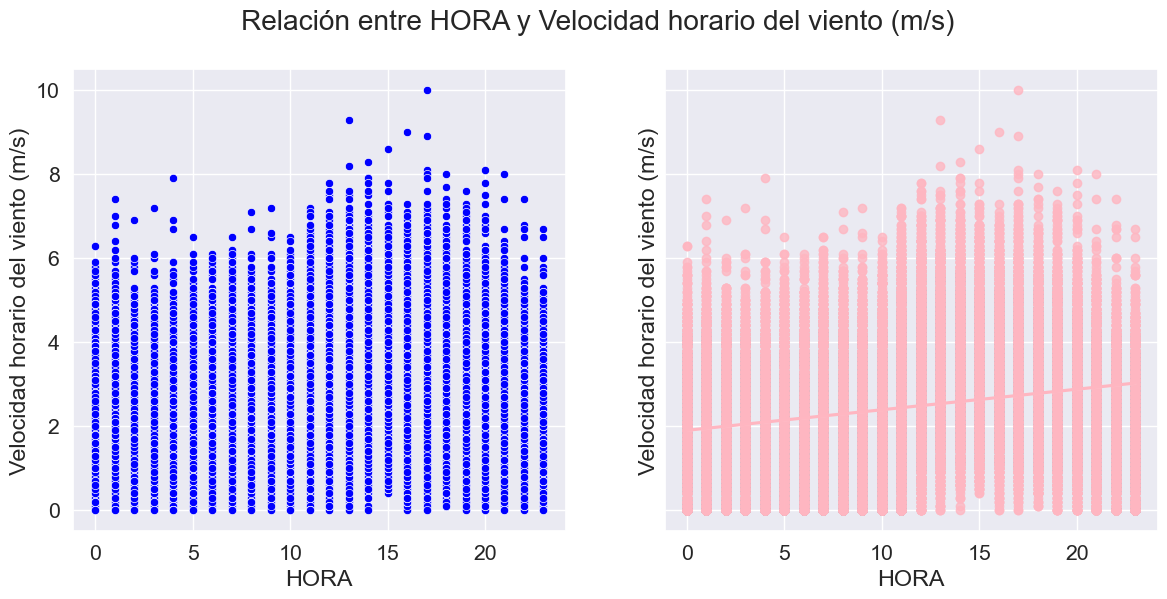

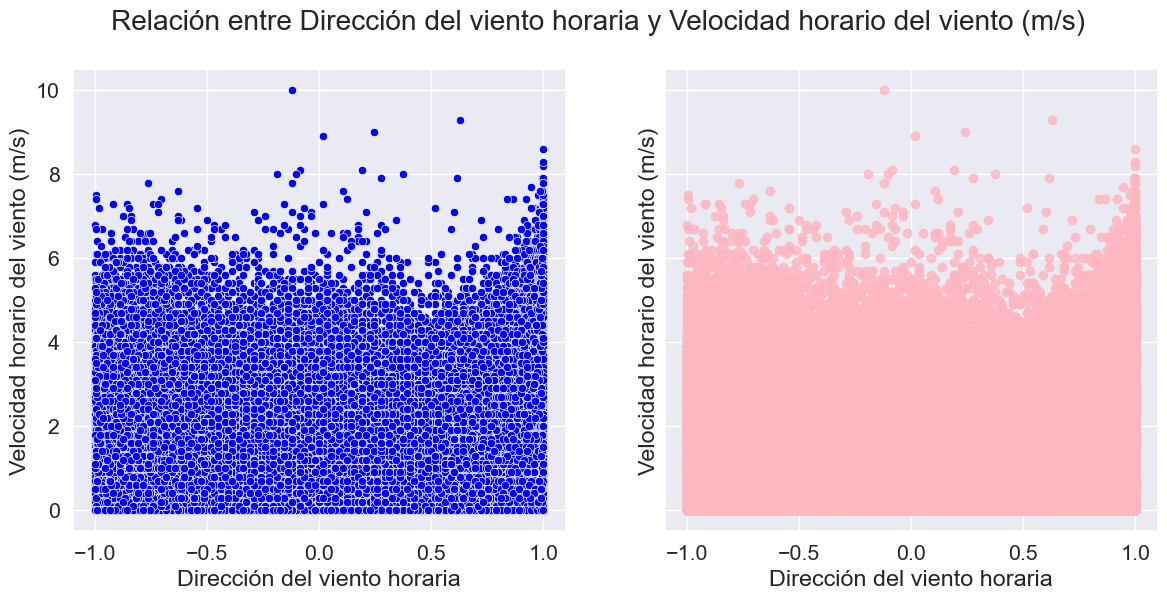

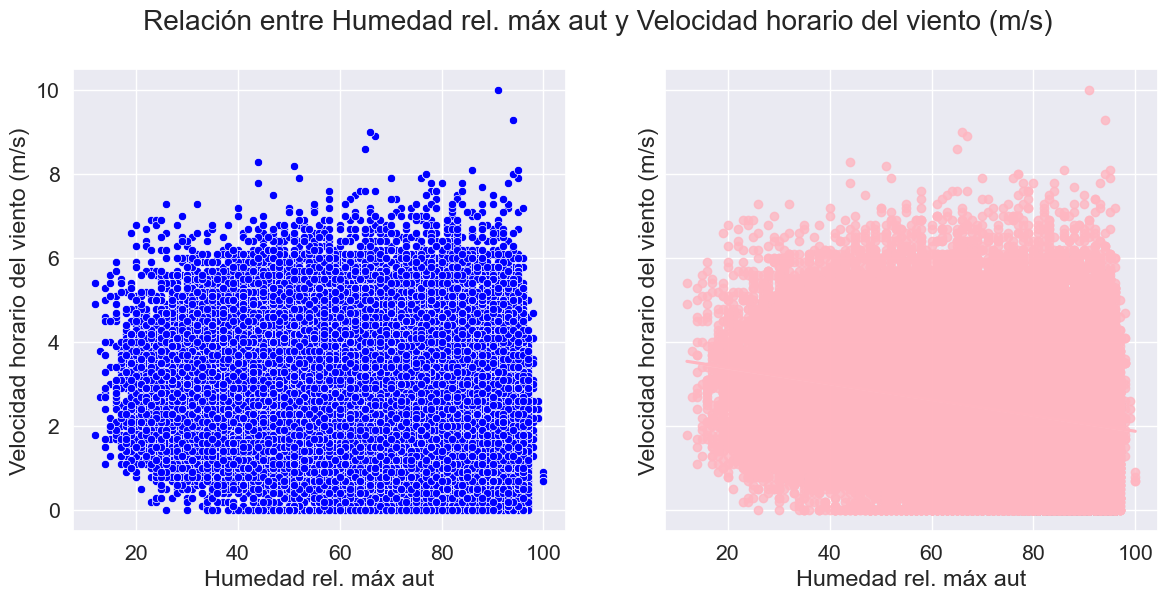

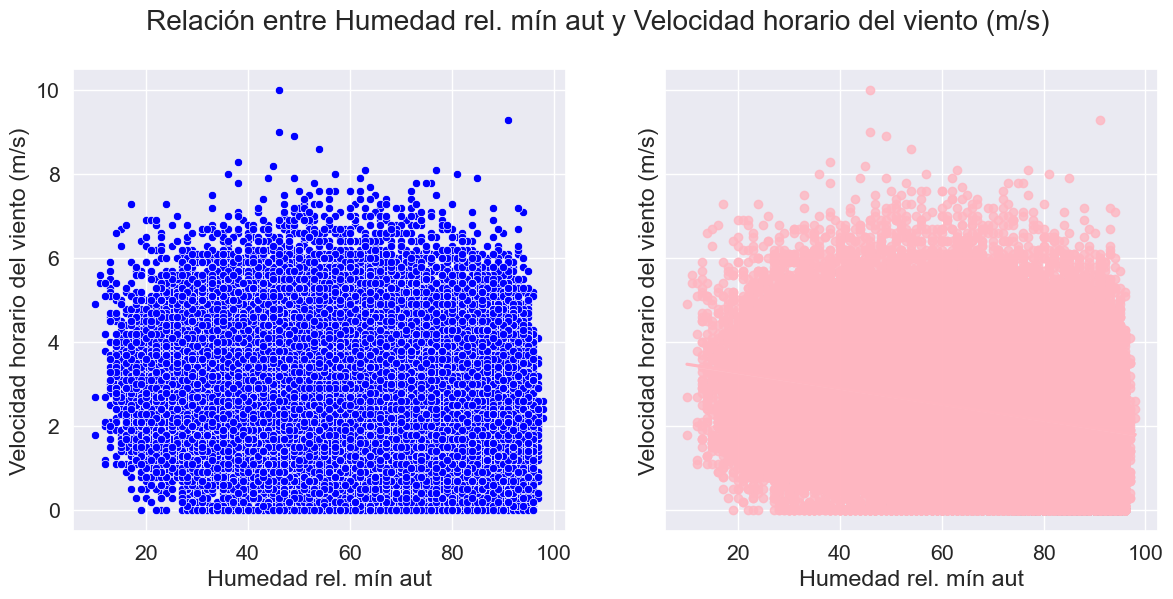

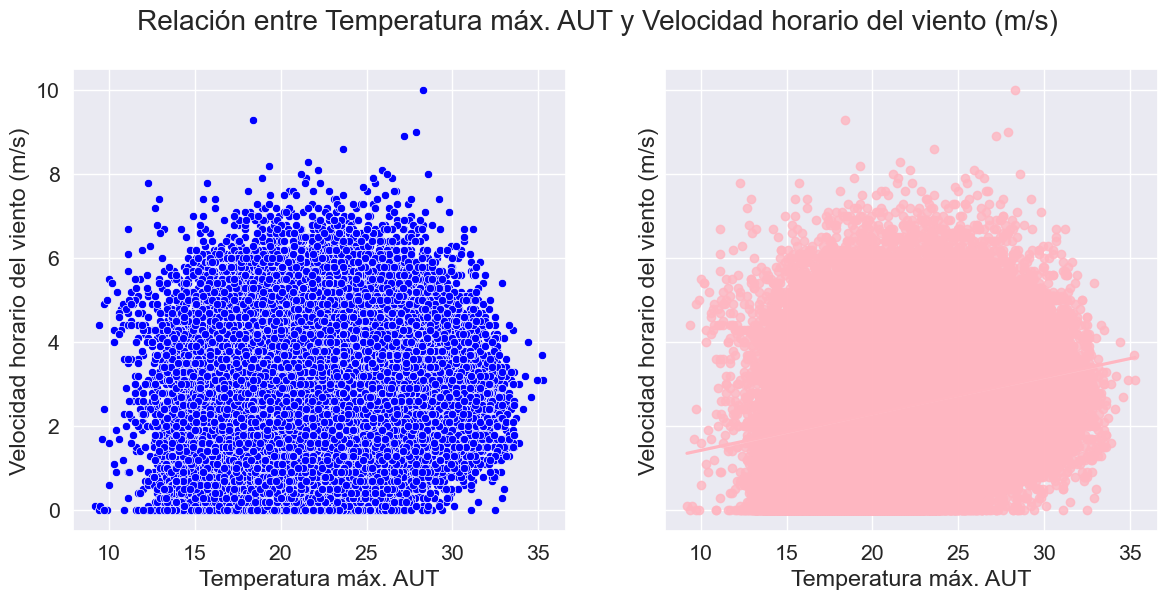

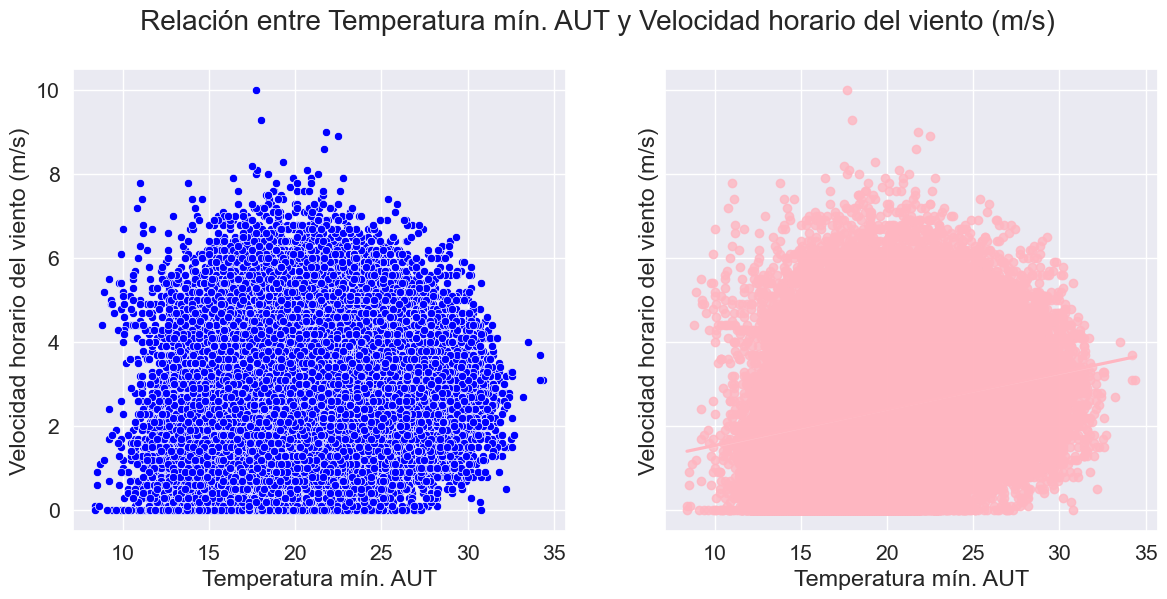

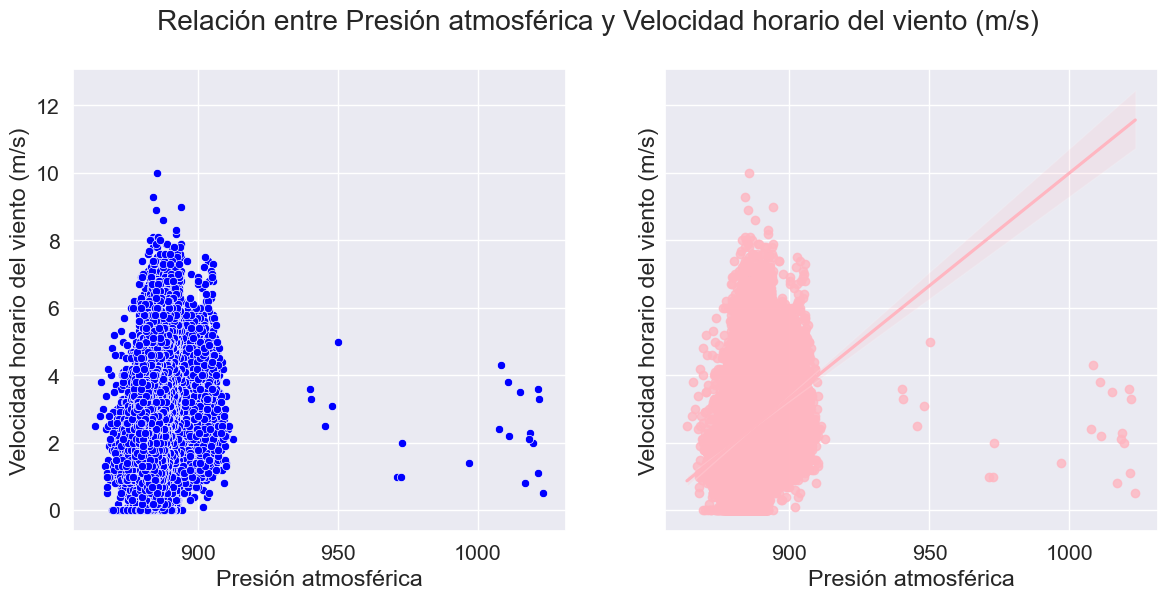

In [22]:
num_cols.remove('Velocidad horario del viento (m/s)')
for col in num_cols:
    scatter_regplot(wind, col, 'Velocidad horario del viento (m/s)')

Principalmente se encuentra una relacion relacion positiva entre los datos de maxima rafaga de viento y la velocidad horaria del viento, a mayor sea la rafaga maxima de viento, mayor sera la velocidad horaria de viento, esta relacion positiva se ve tambien, pero en menor medida al comparar los niveles de presion atmosferica con la velocidad del viento, es decir, a mayor presion atmosferica, mayor sera la velocidad del viento

Debido a esta alta correlacion que se logra observar en estos graficos, es importante realizar una eliminacion de varios de estos datos para evitar un alto porcentaje de overfitting pues muchos de estos resultados son similares entre ellos, para esto utilizamos variance inflation factor (VIF)

In [23]:
h=wind

In [24]:
wind=h

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = wind
vif_data = pd.DataFrame()
vif_data["feature"] = wind.columns


vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                            for i in range(len(X.columns))]
print(vif_data)

                               feature            VIF
0                                 HORA       5.756670
1         Dirección del viento horaria       1.764667
2   Velocidad horario del viento (m/s)      21.472214
3                 Humedad rel. máx aut    1041.288556
4                 Humedad rel. mín aut     873.592599
5                 Temperatura máx. AUT    2458.166449
6                 Temperatura mín. AUT    2040.043966
7                     Humedad relativa     605.398786
8                  Presión atmosférica  239729.935606
9                  Precipitación total       1.166410
10             Máxima ráfaga de viento      30.803252
11                       Presiatmosmax  948462.460794
12            Presión atmosférica mín.  969396.513182


In [26]:
wind = wind.drop('Presión atmosférica mín.', axis=1)
X = wind
vif_data = pd.DataFrame()
vif_data["feature"] = wind.columns


vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                            for i in range(len(X.columns))]
  
print(vif_data)

                               feature            VIF
0                                 HORA       5.732878
1         Dirección del viento horaria       1.764655
2   Velocidad horario del viento (m/s)      21.472100
3                 Humedad rel. máx aut    1041.223639
4                 Humedad rel. mín aut     872.675000
5                 Temperatura máx. AUT    2433.989389
6                 Temperatura mín. AUT    2019.894779
7                     Humedad relativa     605.025952
8                  Presión atmosférica  221975.361285
9                  Precipitación total       1.165461
10             Máxima ráfaga de viento      30.799789
11                       Presiatmosmax  222530.244342


In [27]:
wind = wind.drop('Presión atmosférica', axis=1)
X = wind
vif_data = pd.DataFrame()
vif_data["feature"] = wind.columns


vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                            for i in range(len(X.columns))]
  
print(vif_data)

                               feature          VIF
0                                 HORA     5.729686
1         Dirección del viento horaria     1.764260
2   Velocidad horario del viento (m/s)    21.462936
3                 Humedad rel. máx aut  1041.179234
4                 Humedad rel. mín aut   872.655012
5                 Temperatura máx. AUT  2433.413757
6                 Temperatura mín. AUT  2019.770603
7                     Humedad relativa   604.840542
8                  Precipitación total     1.164753
9              Máxima ráfaga de viento    30.780160
10                       Presiatmosmax   168.716547


In [28]:
wind = wind.drop('Temperatura máx. AUT', axis=1)
X = wind
vif_data = pd.DataFrame()
vif_data["feature"] = wind.columns


vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                            for i in range(len(X.columns))]
  
print(vif_data)

                              feature         VIF
0                                HORA    5.692848
1        Dirección del viento horaria    1.752916
2  Velocidad horario del viento (m/s)   21.346132
3                Humedad rel. máx aut  483.338846
4                Humedad rel. mín aut  398.127100
5                Temperatura mín. AUT   74.975563
6                    Humedad relativa  600.072686
7                 Precipitación total    1.146077
8             Máxima ráfaga de viento   30.487909
9                       Presiatmosmax  144.087171


In [29]:
wind = wind.drop('Humedad rel. máx aut', axis=1)
X = wind
vif_data = pd.DataFrame()
vif_data["feature"] = wind.columns


vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                            for i in range(len(X.columns))]
  
print(vif_data)

                              feature         VIF
0                                HORA    5.555548
1        Dirección del viento horaria    1.743150
2  Velocidad horario del viento (m/s)   21.344828
3                Humedad rel. mín aut  359.693193
4                Temperatura mín. AUT   74.478535
5                    Humedad relativa  403.370714
6                 Precipitación total    1.145611
7             Máxima ráfaga de viento   30.466511
8                       Presiatmosmax  139.778996


In [30]:
wind = wind.drop('Humedad relativa', axis=1)
X = wind
vif_data = pd.DataFrame()
vif_data["feature"] = wind.columns


vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                            for i in range(len(X.columns))]
  
print(vif_data)

                              feature         VIF
0                                HORA    5.484705
1        Dirección del viento horaria    1.709306
2  Velocidad horario del viento (m/s)   20.806823
3                Humedad rel. mín aut   21.503967
4                Temperatura mín. AUT   73.257269
5                 Precipitación total    1.116221
6             Máxima ráfaga de viento   29.886266
7                       Presiatmosmax  133.061080


In [31]:
wind = wind.drop('Presiatmosmax', axis=1)
X = wind
vif_data = pd.DataFrame()
vif_data["feature"] = wind.columns


vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                            for i in range(len(X.columns))]
  
print(vif_data)

                              feature        VIF
0                                HORA   5.468956
1        Dirección del viento horaria   1.502811
2  Velocidad horario del viento (m/s)  20.742039
3                Humedad rel. mín aut   6.401121
4                Temperatura mín. AUT  17.914017
5                 Precipitación total   1.116128
6             Máxima ráfaga de viento  29.881085


In [32]:
wind = wind.drop('Máxima ráfaga de viento', axis=1)
X = wind
vif_data = pd.DataFrame()
vif_data["feature"] = wind.columns


vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                            for i in range(len(X.columns))]
  
print(vif_data)

                              feature        VIF
0                                HORA   5.335222
1        Dirección del viento horaria   1.484971
2  Velocidad horario del viento (m/s)   5.254167
3                Humedad rel. mín aut   6.373875
4                Temperatura mín. AUT  15.915692
5                 Precipitación total   1.042880


In [33]:
wind = wind.drop('Temperatura mín. AUT', axis=1)
X = wind
vif_data = pd.DataFrame()
vif_data["feature"] = wind.columns


vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                            for i in range(len(X.columns))]
  
print(vif_data)

                              feature       VIF
0                                HORA  3.303058
1        Dirección del viento horaria  1.455961
2  Velocidad horario del viento (m/s)  4.550451
3                Humedad rel. mín aut  3.050518
4                 Precipitación total  1.029911


## MODELOS

In [212]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score


In [213]:
svm_modelR = SVC(kernel='linear', max_iter=50,probability=True, random_state=123)
xb_modelR = XGBClassifier(random_state=123)
knn_modelR = KNeighborsRegressor()
nb_modelR = GaussianNB()
mlp_classifierR = MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=20,random_state=123)
lasso_classifierR = LogisticRegression(penalty='l1', solver='liblinear', random_state=123)

In [36]:
X = wind.drop(columns=['Velocidad horario del viento (m/s)'])
y = wind['Velocidad horario del viento (m/s)']  #

In [37]:
y_24 = y.shift(-24)
y_48 = y.shift(-48)
y_72 = y.shift(-72)
y_96 = y.shift(-96)
y_120 = y.shift(-120)

In [38]:
X = X[:-120] 
y = y[:-120]  
y_24 = y_24[:-120]
y_48 = y_48[:-120]
y_72 = y_72[:-120]
y_96 = y_96[:-120]
y_120 = y_120[:-120]


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

KNN


In [40]:
model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
rmse=np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Mean Squared Error (MSE): 1.26522386525835
Root Mean Squared Error (RMSE): 1.124821703763912
R-squared (R²): 0.2632309495934181


RIDGE

In [41]:
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

Ridge()

In [42]:
y_pred = model.predict(X_test)

In [43]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [44]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Calcula la raíz cuadrada del MSE
r2 = r2_score(y_test, y_pred)

In [45]:
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Mean Squared Error (MSE): 1.4678156658832027
Root Mean Squared Error (RMSE): 1.2115344262063719
R-squared (R²): 0.1452570695037838


LASSO

In [46]:
model = Lasso(alpha=1.0)
model.fit(X_train, y_train)

# Realiza predicciones
y_pred = model.predict(X_test)

# Evalúa el modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Mean Squared Error (MSE): 1.548858051929018
Root Mean Squared Error (RMSE): 1.244531257915613
R-squared (R²): 0.09806421814426025


XGBOOST

In [47]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# Realiza predicciones
y_pred = model.predict(X_test)

# Evalúa el modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Mean Squared Error (MSE): 1.055014753804481
Root Mean Squared Error (RMSE): 1.0271391112232466
R-squared (R²): 0.3856405655399636


SVM

In [50]:
model = SVR(kernel='linear', max_iter=10)
model.fit(X_train, y_train)

# Realiza predicciones
y_pred = model.predict(X_test)

# Evalúa el modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Mean Squared Error (MSE): 557.2741237215978
Root Mean Squared Error (RMSE): 23.606654225484768
R-squared (R²): -323.51358073828584


MLP

In [51]:
model = MLPRegressor(hidden_layer_sizes=(10, 10), max_iter=20,random_state=123)
model.fit(X_train, y_train)

# Realiza predicciones
y_pred = model.predict(X_test)

# Evalúa el modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Mean Squared Error (MSE): 1.2841786683531768
Root Mean Squared Error (RMSE): 1.1332160731092622
R-squared (R²): 0.25219313038980407
